1. Transportation Engineering: Traffic Volume Time Series


/tmp/ipython-input-935534164.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range('2024-01-01', periods=n, freq='H')


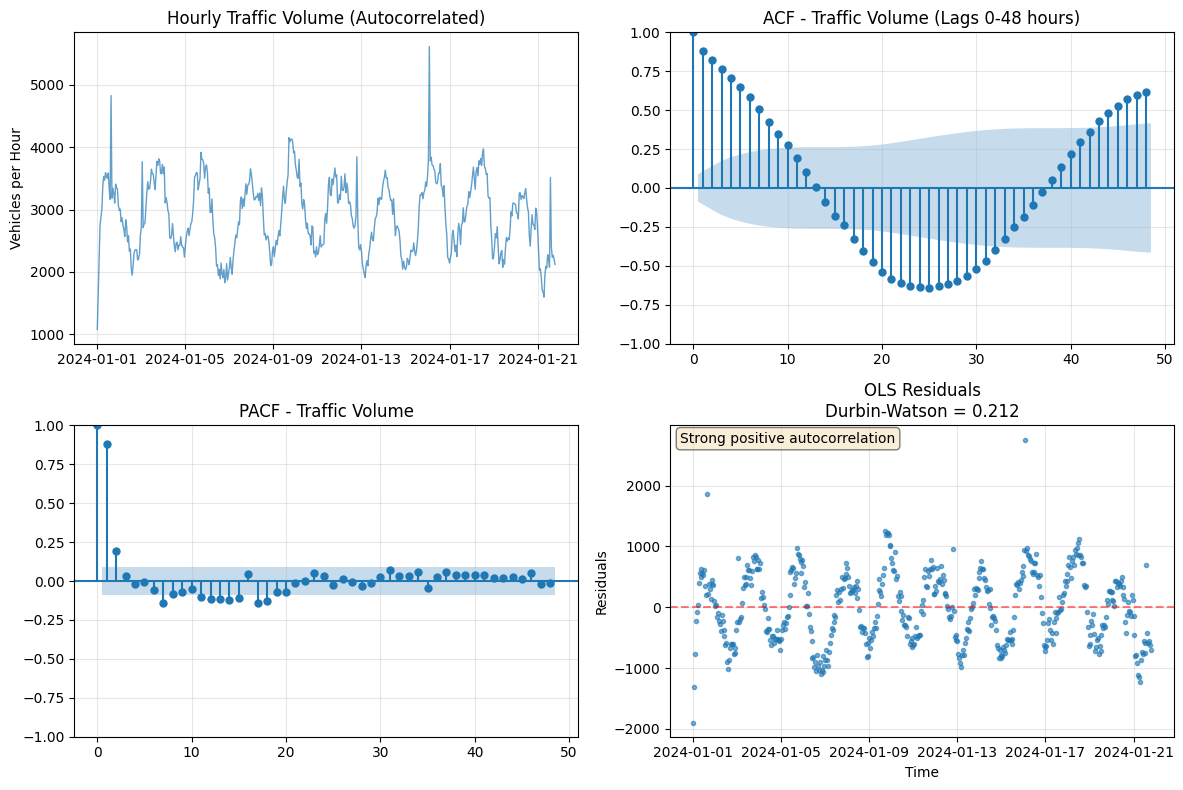


=== TRAFFIC VOLUME AUTOCORRELATION ANALYSIS ===
Dataset: 500 hourly observations
Mean traffic: 2897 vehicles/hour
Std traffic: 575 vehicles/hour
Durbin-Watson statistic: 0.212
→ Values near 2: no autocorrelation
→ Values toward 0: positive autocorrelation
→ Values toward 4: negative autocorrelation



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# Generate realistic hourly traffic volume data with autocorrelation (AR process)
np.random.seed(42)
n = 500  # ~21 days of hourly data
time_index = pd.date_range('2024-01-01', periods=n, freq='H')

# Create daily pattern (higher during day, lower at night)
daily_pattern = np.sin(np.linspace(0, 20*np.pi, n)) + 1.5

# Create weekly pattern (lower on weekends)
day_of_week = time_index.dayofweek
weekly_pattern = np.where(day_of_week < 5, 1.0, 0.6)  # 60% on weekends

# AR(1) process: traffic(t) = 0.7*traffic(t-1) + noise
base_traffic = 1000  # base volume
ar_coef = 0.7
noise = np.random.normal(0, 150, n)

traffic_volume = np.zeros(n)
traffic_volume[0] = base_traffic + noise[0]

for t in range(1, n):
    traffic_volume[t] = (base_traffic +
                        ar_coef * (traffic_volume[t-1] - base_traffic) +
                        daily_pattern[t] * 200 +
                        weekly_pattern[t] * 300 +
                        noise[t])

# Add outliers (accidents/special events)
outlier_indices = np.random.choice(n, 5, replace=False)
traffic_volume[outlier_indices] *= 1.5

# Create DataFrame
df_traffic = pd.DataFrame({
    'timestamp': time_index,
    'traffic_volume': traffic_volume,
    'hour': time_index.hour,
    'day_of_week': day_of_week
})
df_traffic.set_index('timestamp', inplace=True)

# Plot time series
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Time series plot
axes[0, 0].plot(df_traffic.index, df_traffic['traffic_volume'], linewidth=1, alpha=0.7)
axes[0, 0].set_title('Hourly Traffic Volume (Autocorrelated)', fontsize=12)
axes[0, 0].set_ylabel('Vehicles per Hour')
axes[0, 0].grid(True, alpha=0.3)

# ACF plot
plot_acf(df_traffic['traffic_volume'], lags=48, ax=axes[0, 1],
         title=f'ACF - Traffic Volume (Lags 0-48 hours)')
axes[0, 1].grid(True, alpha=0.3)

# PACF plot
plot_pacf(df_traffic['traffic_volume'], lags=48, ax=axes[1, 0],
         title=f'PACF - Traffic Volume')
axes[1, 0].grid(True, alpha=0.3)

# Durbin-Watson test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# Fit OLS model (naive approach ignoring autocorrelation)
X = sm.add_constant(np.arange(len(df_traffic)))  # Simple time trend
y = df_traffic['traffic_volume']
model_naive = sm.OLS(y, X).fit()
dw_stat = durbin_watson(model_naive.resid)

# Create synthetic OLS vs GLS comparison
# For visualization, show residuals autocorrelation
residuals = model_naive.resid
axes[1, 1].plot(residuals.index, residuals, 'o', alpha=0.6, markersize=3)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title(f'OLS Residuals\nDurbin-Watson = {dw_stat:.3f}')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_xlabel('Time')
axes[1, 1].grid(True, alpha=0.3)

# Add DW interpretation
if dw_stat < 1.5:
    dw_text = "Strong positive autocorrelation"
elif dw_stat > 2.5:
    dw_text = "Strong negative autocorrelation"
else:
    dw_text = "No significant autocorrelation"

axes[1, 1].text(0.02, 0.98, dw_text, transform=axes[1, 1].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n=== TRAFFIC VOLUME AUTOCORRELATION ANALYSIS ===")
print(f"Dataset: {n} hourly observations")
print(f"Mean traffic: {traffic_volume.mean():.0f} vehicles/hour")
print(f"Std traffic: {traffic_volume.std():.0f} vehicles/hour")
print(f"Durbin-Watson statistic: {dw_stat:.3f}")
print("→ Values near 2: no autocorrelation")
print("→ Values toward 0: positive autocorrelation")
print("→ Values toward 4: negative autocorrelation")
print("\n" + "="*50)

2. Pavement Engineering: Pavement Roughness Measurement


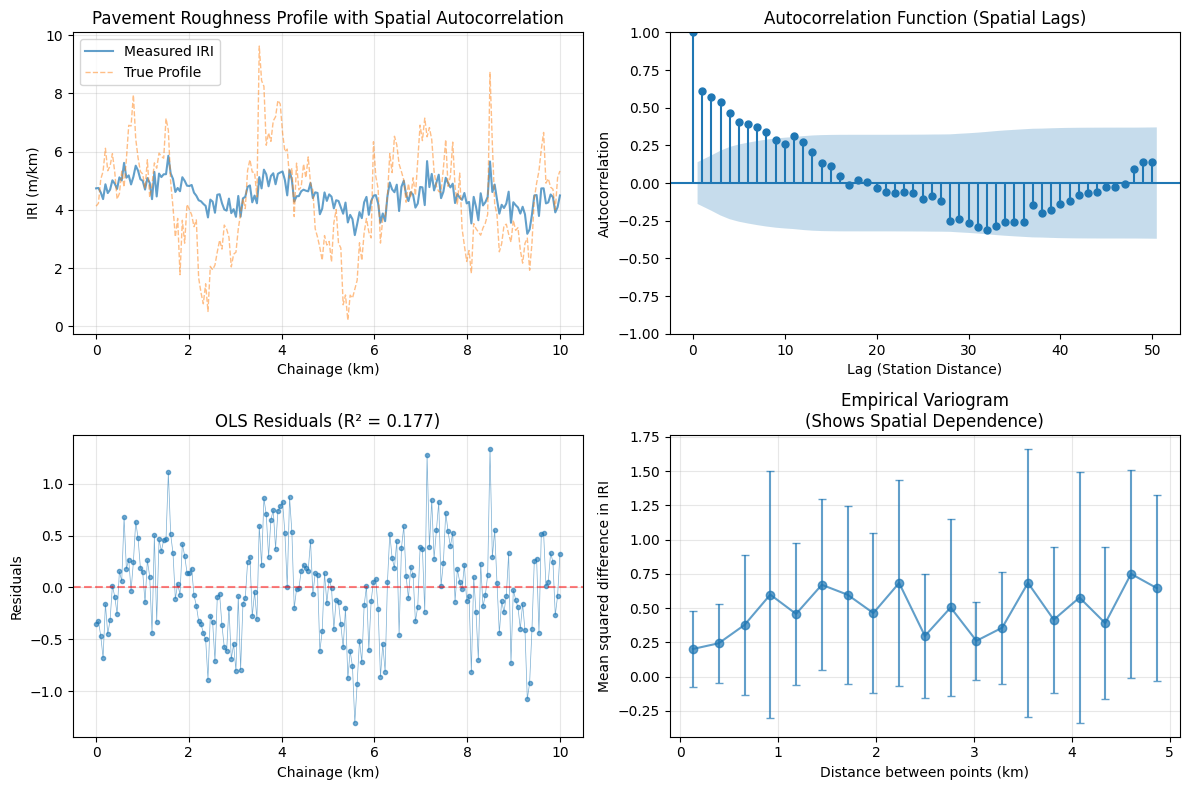


=== PAVEMENT ROUGHNESS ANALYSIS ===
Road length: 10.0 km
Measurement points: 200
Mean IRI: 4.52 m/km
IRI range: [3.13, 5.86] m/km
OLS R-squared: 0.177
Note: Spatial autocorrelation violates OLS independence assumption



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

# Generate pavement roughness data with spatial autocorrelation
np.random.seed(43)
n_points = 200  # measurement points along a 10km road
road_length = 10000  # 10 km in meters
station_locations = np.linspace(0, road_length, n_points)

# True underlying roughness profile (smooth with bumps)
true_profile = (np.sin(station_locations/500) * 2 +  # long wavelength variation
                np.sin(station_locations/100) * 1 +  # medium wavelength
                np.random.normal(0, 0.5, n_points))  # random noise

# Add specific defects at certain locations
defect_locations = [1500, 3500, 6000, 8500]
defect_sizes = [3, 5, 4, 6]
for loc, size in zip(defect_locations, defect_sizes):
    idx = np.argmin(np.abs(station_locations - loc))
    true_profile[idx:idx+10] += size * np.exp(-np.arange(10)/3)

# Measurement with spatial autocorrelation (IRI values in m/km)
# Spatial AR process: IRI(x) depends on nearby points
iri_values = np.zeros(n_points)
iri_values[0] = true_profile[0] + np.random.normal(0, 0.3)

# Create spatial autocorrelation
spatial_correlation = 0.8  # correlation decays with distance
for i in range(1, n_points):
    # Distance to previous points (weighted average)
    weights = np.exp(-np.abs(np.arange(i, 0, -1)) / 20)  # Exponential decay
    weighted_avg = np.sum(weights * iri_values[:i]) / np.sum(weights)
    iri_values[i] = (spatial_correlation * weighted_avg +
                     (1 - spatial_correlation) * true_profile[i] +
                     np.random.normal(0, 0.3))

# Ensure IRI is positive and in typical range (1-10 m/km)
iri_values = np.clip(iri_values + 4, 1, 10)

# Create DataFrame
df_pavement = pd.DataFrame({
    'station': station_locations,
    'iri': iri_values,
    'true_profile': true_profile + 4,
    'chainage_km': station_locations / 1000
})

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Roughness profile along road
axes[0, 0].plot(df_pavement['chainage_km'], df_pavement['iri'],
                label='Measured IRI', linewidth=1.5, alpha=0.7)
axes[0, 0].plot(df_pavement['chainage_km'], df_pavement['true_profile'],
                label='True Profile', linewidth=1, alpha=0.5, linestyle='--')
axes[0, 0].set_xlabel('Chainage (km)')
axes[0, 0].set_ylabel('IRI (m/km)')
axes[0, 0].set_title('Pavement Roughness Profile with Spatial Autocorrelation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ACF plot (treating spatial sequence as time series)
plot_acf(df_pavement['iri'], lags=50, ax=axes[0, 1],
         title='Autocorrelation Function (Spatial Lags)')
axes[0, 1].set_xlabel('Lag (Station Distance)')
axes[0, 1].set_ylabel('Autocorrelation')

# 3. Residuals from polynomial trend (showing autocorrelation in errors)
# Fit polynomial to capture general trend
X = np.column_stack([df_pavement['station'],
                     df_pavement['station']**2,
                     df_pavement['station']**3])
X = sm.add_constant(X)
model = sm.OLS(df_pavement['iri'], X).fit()
df_pavement['residuals'] = model.resid

axes[1, 0].plot(df_pavement['chainage_km'], df_pavement['residuals'],
                'o-', alpha=0.6, markersize=3, linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Chainage (km)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title(f'OLS Residuals (R² = {model.rsquared:.3f})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Variogram-like plot (spatial autocorrelation structure)
# Calculate pairwise distances and squared differences
distances = []
squared_diffs = []

# Sample pairs for efficiency
sample_size = min(1000, n_points*(n_points-1)//2)
for _ in range(sample_size):
    i, j = np.random.choice(n_points, 2, replace=False)
    dist = abs(station_locations[i] - station_locations[j])
    diff = (iri_values[i] - iri_values[j])**2
    distances.append(dist)
    squared_diffs.append(diff)

# Bin distances
dist_bins = np.linspace(0, road_length/2, 20)
bin_means = []
bin_stds = []
for i in range(len(dist_bins)-1):
    mask = (np.array(distances) >= dist_bins[i]) & (np.array(distances) < dist_bins[i+1])
    if np.sum(mask) > 0:
        bin_means.append(np.mean(np.array(squared_diffs)[mask]))
        bin_stds.append(np.std(np.array(squared_diffs)[mask]))
    else:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)

bin_centers = (dist_bins[:-1] + dist_bins[1:]) / 2

axes[1, 1].errorbar(bin_centers/1000, bin_means, yerr=bin_stds,
                    fmt='o-', alpha=0.7, capsize=3)
axes[1, 1].set_xlabel('Distance between points (km)')
axes[1, 1].set_ylabel('Mean squared difference in IRI')
axes[1, 1].set_title('Empirical Variogram\n(Shows Spatial Dependence)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== PAVEMENT ROUGHNESS ANALYSIS ===")
print(f"Road length: {road_length/1000:.1f} km")
print(f"Measurement points: {n_points}")
print(f"Mean IRI: {df_pavement['iri'].mean():.2f} m/km")
print(f"IRI range: [{df_pavement['iri'].min():.2f}, {df_pavement['iri'].max():.2f}] m/km")
print(f"OLS R-squared: {model.rsquared:.3f}")
print("Note: Spatial autocorrelation violates OLS independence assumption")
print("\n" + "="*50)

3. Environmental Engineering: Air Pollution Monitoring


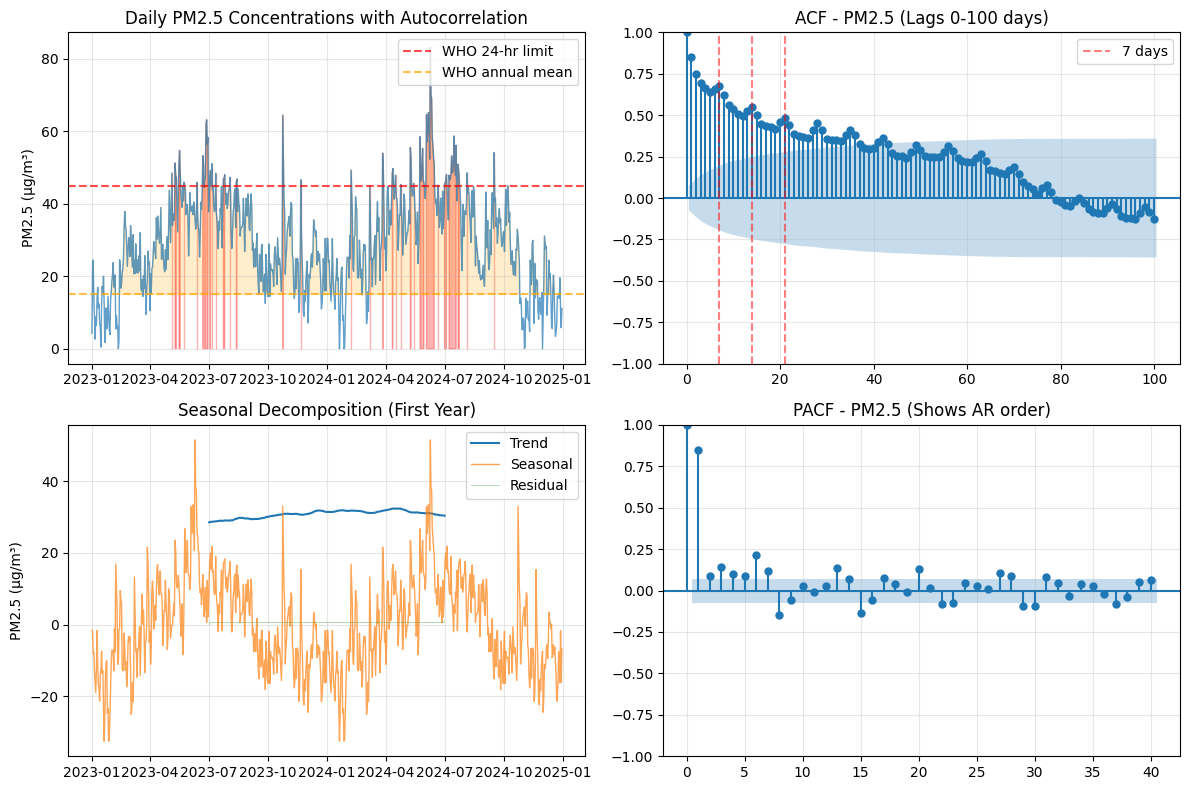


=== AIR POLLUTION AUTOCORRELATION ANALYSIS ===
Dataset: 730 daily PM2.5 measurements
Mean PM2.5: 29.5 μg/m³
Std PM2.5: 13.3 μg/m³
Days > 45 μg/m³: 83 (11.4%)
Days > 15 μg/m³: 626 (85.8%)

Statistical Tests:
Augmented Dickey-Fuller test p-value: 0.1460
→ p < 0.05: Data is stationary (reject null hypothesis of unit root)
Durbin-Watson statistic: 0.292
→ Indicates strong positive autocorrelation

Implications for Environmental Models:
1. OLS regression on daily data will underestimate standard errors
2. Time series models (ARIMA, SARIMA) needed for accurate forecasting
3. Exceedance probabilities are correlated across days



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Generate realistic daily PM2.5 data with seasonality and autocorrelation
np.random.seed(44)
n_days = 365 * 2  # 2 years of daily data
dates = pd.date_range('2023-01-01', periods=n_days, freq='D')

# 1. Seasonal component (higher in winter, lower in summer)
day_of_year = dates.dayofyear
seasonal = 15 * np.sin(2 * np.pi * day_of_year / 365 - np.pi/2) + 25  # Range ~10-40 μg/m³

# 2. Weekly pattern (lower on weekends due to less traffic)
day_of_week = dates.dayofweek
weekly = np.where(day_of_week < 5, 5, -2)  # Weekdays higher

# 3. AR(2) process for persistence (pollution yesterday affects today)
ar_coefs = [0.6, 0.2]  # AR(2) coefficients
noise = np.random.normal(0, 5, n_days)  # Random fluctuations

# Generate AR process
pm25 = np.zeros(n_days)
pm25[:2] = seasonal[:2] + weekly[:2] + noise[:2]

for t in range(2, n_days):
    pm25[t] = (seasonal[t] + weekly[t] +
               ar_coefs[0] * (pm25[t-1] - seasonal[t-1] - weekly[t-1]) +
               ar_coefs[1] * (pm25[t-2] - seasonal[t-2] - weekly[t-2]) +
               noise[t])

# Add some pollution episodes (5-7 day episodes)
episode_days = np.random.choice(n_days, 10, replace=False)
for day in episode_days:
    duration = np.random.randint(3, 8)
    intensity = np.random.uniform(15, 30)
    end = min(day + duration, n_days)
    pm25[day:end] += intensity * np.exp(-np.arange(end-day)/2)

# Ensure non-negative
pm25 = np.maximum(pm25, 0)

# Create DataFrame
df_pollution = pd.DataFrame({
    'date': dates,
    'pm25': pm25,
    'day_of_year': day_of_year,
    'day_of_week': day_of_week,
    'month': dates.month
})
df_pollution.set_index('date', inplace=True)

# Calculate exceedance days (WHO guideline: 15 μg/m³ annual mean, 45 μg/m³ 24-hr)
df_pollution['exceeds_daily'] = df_pollution['pm25'] > 45
df_pollution['exceeds_annual'] = df_pollution['pm25'] > 15

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Time series plot
axes[0, 0].plot(df_pollution.index, df_pollution['pm25'], linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=45, color='r', linestyle='--', alpha=0.7, label='WHO 24-hr limit')
axes[0, 0].axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='WHO annual mean')
axes[0, 0].fill_between(df_pollution.index, 0, df_pollution['pm25'],
                        where=df_pollution['pm25']>45, color='red', alpha=0.3)
axes[0, 0].fill_between(df_pollution.index, 15, df_pollution['pm25'],
                        where=df_pollution['pm25']>15, color='orange', alpha=0.2)
axes[0, 0].set_title('Daily PM2.5 Concentrations with Autocorrelation')
axes[0, 0].set_ylabel('PM2.5 (μg/m³)')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3)

# 2. ACF plot (long lags to see weekly/seasonal patterns)
plot_acf(df_pollution['pm25'], lags=100, ax=axes[0, 1],
         title='ACF - PM2.5 (Lags 0-100 days)')
axes[0, 1].axvline(x=7, color='r', linestyle='--', alpha=0.5, label='7 days')
axes[0, 1].axvline(x=14, color='r', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=21, color='r', linestyle='--', alpha=0.5)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Use first year for seasonal pattern
decomposition = seasonal_decompose(df_pollution['pm25'],
                                  model='additive', period=365)

axes[1, 0].plot(decomposition.trend, label='Trend', linewidth=1.5)
axes[1, 0].plot(decomposition.seasonal, label='Seasonal', linewidth=1, alpha=0.7)
axes[1, 0].plot(decomposition.resid, label='Residual', linewidth=0.5, alpha=0.5)
axes[1, 0].set_title('Seasonal Decomposition (First Year)')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. PACF plot
plot_pacf(df_pollution['pm25'], lags=40, ax=axes[1, 1],
         title='PACF - PM2.5 (Shows AR order)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(df_pollution['pm25'])
# Durbin-Watson test
X = sm.add_constant(np.arange(len(df_pollution)))
model = sm.OLS(df_pollution['pm25'], X).fit()
dw_stat = sm.stats.durbin_watson(model.resid)

print("\n=== AIR POLLUTION AUTOCORRELATION ANALYSIS ===")
print(f"Dataset: {n_days} daily PM2.5 measurements")
print(f"Mean PM2.5: {df_pollution['pm25'].mean():.1f} μg/m³")
print(f"Std PM2.5: {df_pollution['pm25'].std():.1f} μg/m³")
print(f"Days > 45 μg/m³: {df_pollution['exceeds_daily'].sum()} ({df_pollution['exceeds_daily'].mean()*100:.1f}%)")
print(f"Days > 15 μg/m³: {df_pollution['exceeds_annual'].sum()} ({df_pollution['exceeds_annual'].mean()*100:.1f}%)")
print(f"\nStatistical Tests:")
print(f"Augmented Dickey-Fuller test p-value: {adf_result[1]:.4f}")
print(f"→ p < 0.05: Data is stationary (reject null hypothesis of unit root)")
print(f"Durbin-Watson statistic: {dw_stat:.3f}")
print(f"→ Indicates {'strong positive' if dw_stat < 1.5 else 'no significant' if dw_stat > 1.5 and dw_stat < 2.5 else 'strong negative'} autocorrelation")
print("\nImplications for Environmental Models:")
print("1. OLS regression on daily data will underestimate standard errors")
print("2. Time series models (ARIMA, SARIMA) needed for accurate forecasting")
print("3. Exceedance probabilities are correlated across days")
print("\n" + "="*50)

4. Construction Management: Daily Project Productivity


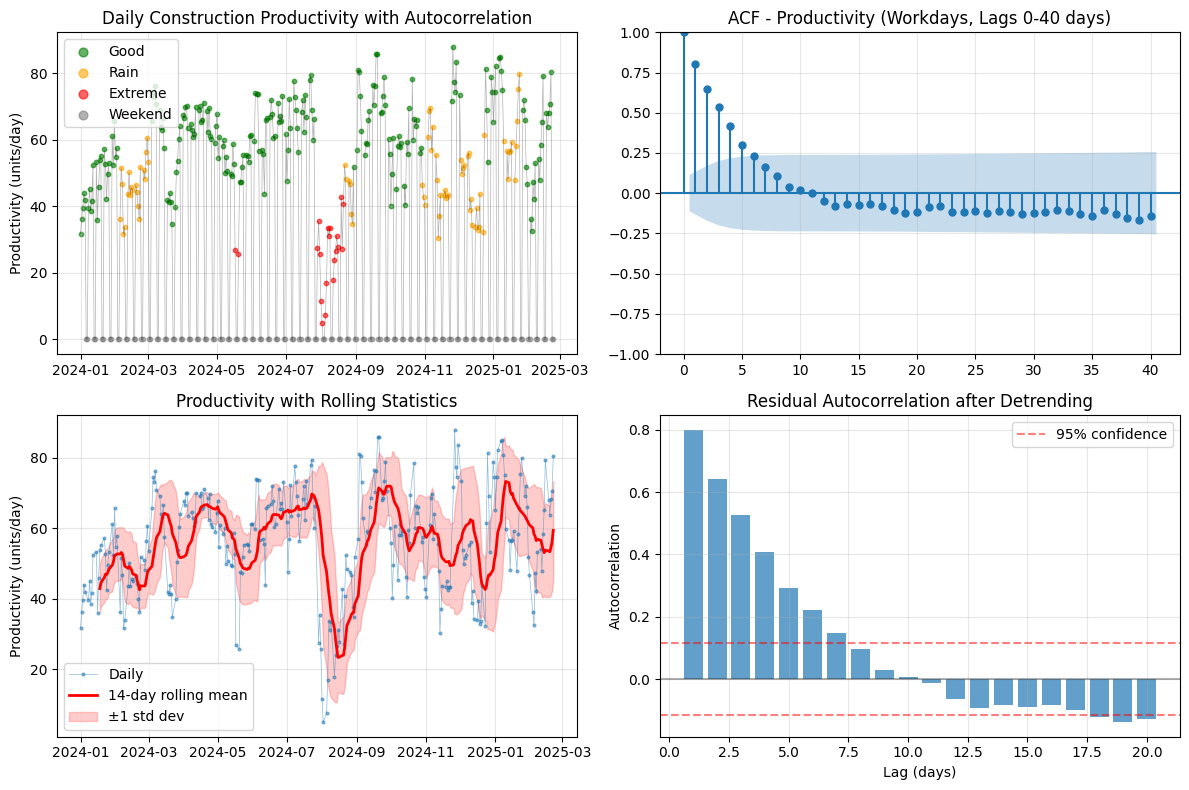


=== CONSTRUCTION PRODUCTIVITY ANALYSIS ===
Project duration: 420 calendar days
Workdays: 300 days
Total production: 16825 units
Average daily productivity: 56.1 units/day
Standard deviation: 15.1 units/day
Coefficient of variation: 26.9%

Weather distribution:
  Good: 209 days (69.7%)
  Rain: 71 days (23.7%)
  Extreme: 20 days (6.7%)

Durbin-Watson statistic: 0.388
→ Indicates strong positive autocorrelation

Management Implications:
1. Traditional earned value analysis assumes independent daily performance
2. Autocorrelation means good/bad days tend to cluster
3. Forecasting completion dates requires time series methods
4. Quality control charts may give false alarms



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

# Generate daily construction productivity data
np.random.seed(45)
n_days = 300  # ~14 months of workdays (excluding weekends)
dates = pd.date_range('2024-01-01', periods=n_days, freq='B')  # Business days

# Base productivity (cubic meters of concrete poured per day)
base_productivity = 50

# 1. Learning curve effect (productivity improves then plateaus)
learning_days = 60
learning_curve = np.minimum(np.arange(n_days) / learning_days * 15, 15)

# 2. Weather effects (random but persistent)
# Generate weather states: 0=good, 1=rain, 2=extreme
weather_states = np.zeros(n_days, dtype=int)
current_state = 0
for i in range(n_days):
    if np.random.random() < 0.1:  # 10% chance to change state
        current_state = np.random.choice([0, 1, 2], p=[0.7, 0.25, 0.05])
    weather_states[i] = current_state

weather_effect = np.where(weather_states == 0, 0,
                         np.where(weather_states == 1, -15, -25))

# 3. Crew availability/material delays (autocorrelated events)
delay_state = 0
delay_effect = np.zeros(n_days)
for i in range(n_days):
    if delay_state > 0:
        delay_effect[i] = -np.random.uniform(10, 20)
        delay_state -= 1
    elif np.random.random() < 0.02:  # 2% chance of delay starting
        delay_state = np.random.randint(3, 10)

# 4. AR(1) process for productivity persistence
ar_coef = 0.65
noise = np.random.normal(0, 8, n_days)

productivity = np.zeros(n_days)
productivity[0] = (base_productivity + learning_curve[0] +
                   weather_effect[0] + delay_effect[0] + noise[0])

for t in range(1, n_days):
    productivity[t] = (base_productivity + learning_curve[t] +
                      weather_effect[t] + delay_effect[t] +
                      ar_coef * (productivity[t-1] - base_productivity -
                                learning_curve[t-1] - weather_effect[t-1] -
                                delay_effect[t-1]) +
                      noise[t])

# Ensure non-negative
productivity = np.maximum(productivity, 5)

# Add weekends (0 productivity)
full_dates = pd.date_range('2024-01-01', periods=n_days+int(n_days*2/5), freq='D')
full_productivity = []
full_weather = []
idx = 0
for date in full_dates:
    if date.weekday() < 5:  # Weekday
        full_productivity.append(productivity[idx])
        full_weather.append(weather_states[idx])
        idx += 1
    else:  # Weekend
        full_productivity.append(0)
        full_weather.append(-1)  # Weekend code

full_productivity = np.array(full_productivity)
full_weather = np.array(full_weather)

# Create DataFrame
df_construction = pd.DataFrame({
    'date': full_dates,
    'productivity': full_productivity,
    'weather': full_weather,
    'is_weekday': (full_dates.weekday < 5).astype(int),
    'week': full_dates.isocalendar().week
})
df_construction.set_index('date', inplace=True)

# Workday-only subset for analysis
df_workdays = df_construction[df_construction['is_weekday'] == 1].copy()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Time series with weekends
colors = ['green', 'orange', 'red', 'gray']
weather_labels = ['Good', 'Rain', 'Extreme', 'Weekend']

for i, weather_code in enumerate([0, 1, 2, -1]):
    mask = df_construction['weather'] == weather_code
    axes[0, 0].scatter(df_construction.index[mask], df_construction['productivity'][mask],
                       color=colors[i], s=10, alpha=0.6, label=weather_labels[i])

axes[0, 0].plot(df_construction.index, df_construction['productivity'],
                'k-', linewidth=0.5, alpha=0.3)
axes[0, 0].set_title('Daily Construction Productivity with Autocorrelation')
axes[0, 0].set_ylabel('Productivity (units/day)')
axes[0, 0].legend(markerscale=2)
axes[0, 0].grid(True, alpha=0.3)

# 2. ACF plot (workdays only)
plot_acf(df_workdays['productivity'], lags=40, ax=axes[0, 1],
         title='ACF - Productivity (Workdays, Lags 0-40 days)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Rolling statistics
window = 14  # 2-week rolling window
df_workdays['rolling_mean'] = df_workdays['productivity'].rolling(window=window).mean()
df_workdays['rolling_std'] = df_workdays['productivity'].rolling(window=window).std()

axes[1, 0].plot(df_workdays.index, df_workdays['productivity'],
                'o-', markersize=2, linewidth=0.5, alpha=0.5, label='Daily')
axes[1, 0].plot(df_workdays.index, df_workdays['rolling_mean'],
                'r-', linewidth=2, label=f'{window}-day rolling mean')
axes[1, 0].fill_between(df_workdays.index,
                        df_workdays['rolling_mean'] - df_workdays['rolling_std'],
                        df_workdays['rolling_mean'] + df_workdays['rolling_std'],
                        alpha=0.2, color='red', label=f'±1 std dev')
axes[1, 0].set_title('Productivity with Rolling Statistics')
axes[1, 0].set_ylabel('Productivity (units/day)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals from trend model
X = sm.add_constant(np.column_stack([np.arange(len(df_workdays)),
                                     np.arange(len(df_workdays))**2]))
model = sm.OLS(df_workdays['productivity'], X).fit()
df_workdays['residuals'] = model.resid

# Calculate autocorrelation in residuals
resid_acf = sm.tsa.acf(df_workdays['residuals'], nlags=20, fft=False)[1:]

axes[1, 1].bar(range(1, 21), resid_acf, alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1, 1].axhline(y=2/np.sqrt(len(df_workdays)), color='r',
                   linestyle='--', alpha=0.5, label='95% confidence')
axes[1, 1].axhline(y=-2/np.sqrt(len(df_workdays)), color='r',
                   linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Lag (days)')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_title('Residual Autocorrelation after Detrending')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
cumulative_production = df_workdays['productivity'].sum()
avg_productivity = df_workdays['productivity'].mean()
std_productivity = df_workdays['productivity'].std()
cv = std_productivity / avg_productivity * 100  # Coefficient of variation

# Durbin-Watson test
dw_stat = sm.stats.durbin_watson(model.resid)

print("\n=== CONSTRUCTION PRODUCTIVITY ANALYSIS ===")
print(f"Project duration: {len(full_dates)} calendar days")
print(f"Workdays: {len(df_workdays)} days")
print(f"Total production: {cumulative_production:.0f} units")
print(f"Average daily productivity: {avg_productivity:.1f} units/day")
print(f"Standard deviation: {std_productivity:.1f} units/day")
print(f"Coefficient of variation: {cv:.1f}%")
print(f"\nWeather distribution:")
for i, label in enumerate(['Good', 'Rain', 'Extreme']):
    count = (df_workdays['weather'] == i).sum()
    print(f"  {label}: {count} days ({count/len(df_workdays)*100:.1f}%)")
print(f"\nDurbin-Watson statistic: {dw_stat:.3f}")
print(f"→ Indicates {'strong positive' if dw_stat < 1.5 else 'no significant' if dw_stat > 1.5 and dw_stat < 2.5 else 'strong negative'} autocorrelation")
print("\nManagement Implications:")
print("1. Traditional earned value analysis assumes independent daily performance")
print("2. Autocorrelation means good/bad days tend to cluster")
print("3. Forecasting completion dates requires time series methods")
print("4. Quality control charts may give false alarms")
print("\n" + "="*50)

5. Urban Traffic Flow Prediction

DATA GENERATION SUMMARY
Time period: 2024-01-01 00:00:00 to 2024-01-21 19:00:00
Sample size: 500 hourly observations
AR(1) coefficient (rho): 0.8
True model: Traffic = f(hour, weekend) + ε, where ε_t = 0.8·ε_{t-1} + ν_t

Descriptive statistics:
       traffic_volume  deterministic   ar_errors
count      500.000000     500.000000  500.000000
mean       753.309556     752.465561    0.843995
std        442.961251     299.177220  320.330797
min       -501.536205     200.000000 -814.995267
25%        425.835166     496.472382 -200.306513
50%        718.982224     800.000000  -11.108573
75%       1069.347097    1000.000000  183.562352
max       1948.006023    1446.410162  885.177301


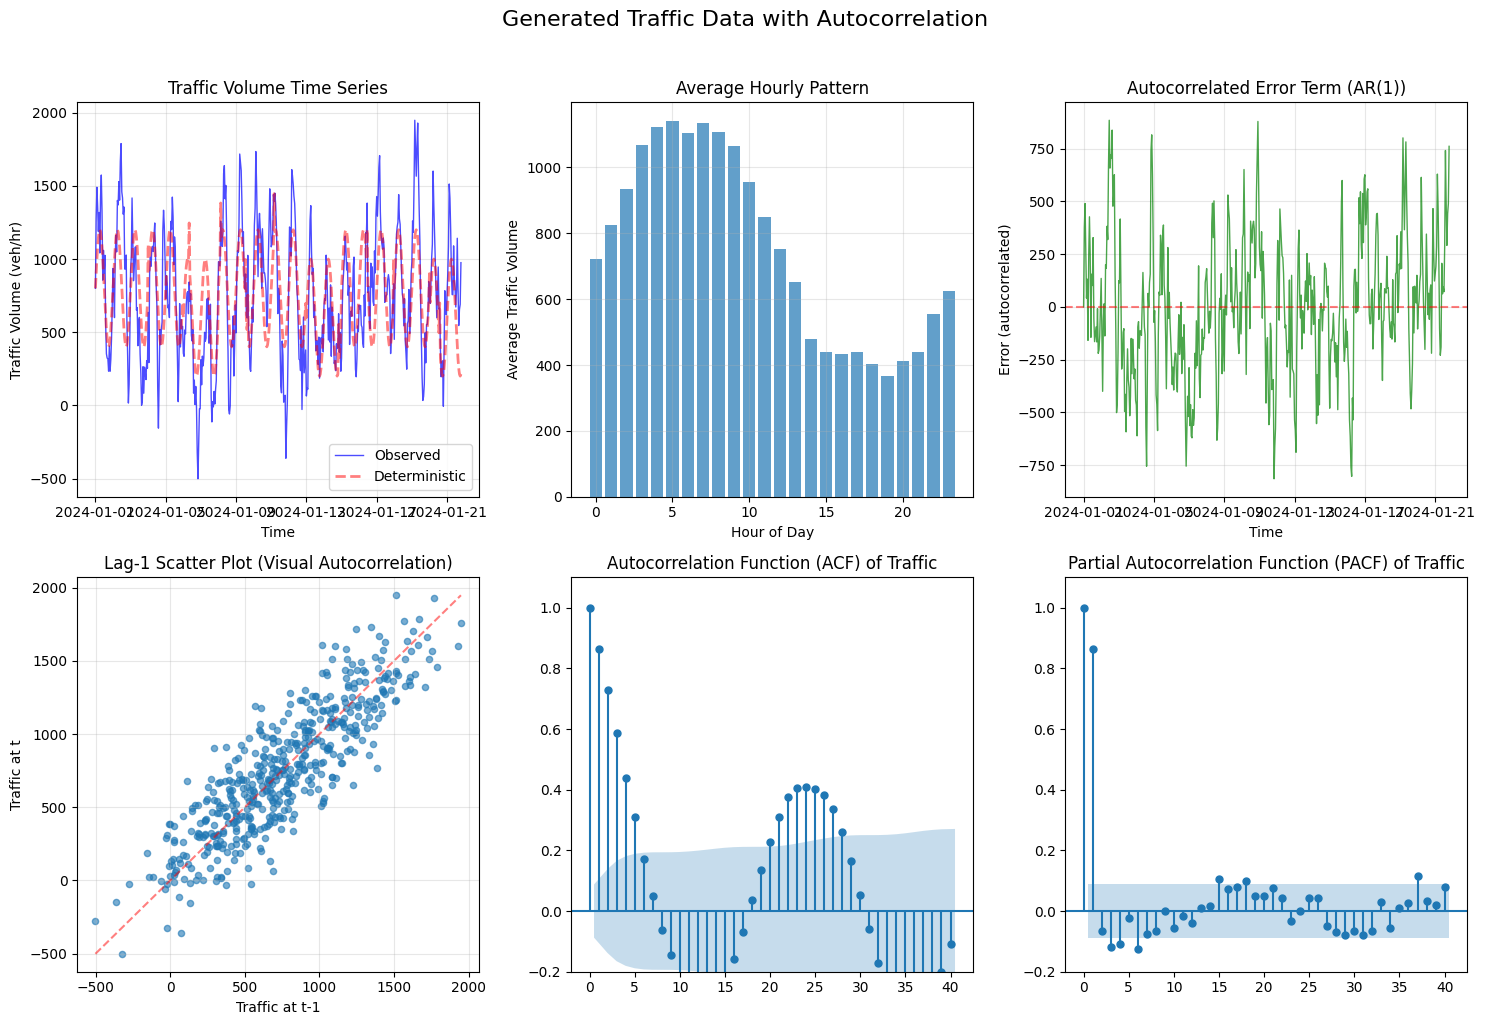


AUTOCORRELATION IN RAW TRAFFIC DATA
Ljung-Box Test (Null: No autocorrelation):
        lb_stat      lb_pvalue
1    375.425899   1.232624e-83
5    962.574437  7.602212e-206
10  1015.241522  9.738223e-212
20  1260.567241  8.195939e-255

Durbin-Watson (approximate for raw data): 0.0698
  Interpretation: DW ≈ 2(1-ρ)
  Estimated ρ from DW: 0.9651
  True ρ used in generation: 0.8000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# ============================================
# GENERATE AUTOCORRELATED TRAFFIC DATA
# ============================================
n_hours = 500  # About 3 weeks of hourly data

# Create time index
time_index = pd.date_range('2024-01-01', periods=n_hours, freq='H')

# Predictors: hour of day and weekday/weekend
hour_of_day = np.array([t.hour for t in time_index])
day_of_week = np.array([t.weekday() for t in time_index])
is_weekend = (day_of_week >= 5).astype(int)

# True relationship (deterministic component)
# Base pattern: higher during rush hours, lower at night
base_traffic = 800 + 400 * np.sin(2*np.pi*hour_of_day/24)  # Daily pattern
weekend_effect = -200 * is_weekend  # Less traffic on weekends
special_events = 300 * (np.random.rand(n_hours) < 0.02)  # Random events

# Deterministic component
deterministic = base_traffic + weekend_effect + special_events

# ============================================
# CREATE STRONG AUTOCORRELATION IN ERRORS
# ============================================
# AR(1) process: ε_t = 0.8ε_{t-1} + ν_t (STRONG autocorrelation)
rho = 0.8  # Autocorrelation coefficient
nu = np.random.normal(0, 100, n_hours)  # White noise

# Generate AR(1) errors
ar_errors = np.zeros(n_hours)
for t in range(1, n_hours):
    ar_errors[t] = rho * ar_errors[t-1] + nu[t]

# Scale errors to make autocorrelation obvious
ar_errors = ar_errors * 2

# Observed traffic = deterministic + autocorrelated errors
traffic = deterministic + ar_errors

# Create DataFrame
df = pd.DataFrame({
    'timestamp': time_index,
    'traffic_volume': traffic,
    'hour': hour_of_day,
    'day_of_week': day_of_week,
    'is_weekend': is_weekend,
    'deterministic': deterministic,
    'ar_errors': ar_errors,
    'hour_sin': np.sin(2*np.pi*hour_of_day/24),
    'hour_cos': np.cos(2*np.pi*hour_of_day/24)
})

# Add lagged variable for diagnostic purposes
df['traffic_lag1'] = df['traffic_volume'].shift(1)

print("="*80)
print("DATA GENERATION SUMMARY")
print("="*80)
print(f"Time period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Sample size: {n_hours} hourly observations")
print(f"AR(1) coefficient (rho): {rho}")
print(f"True model: Traffic = f(hour, weekend) + ε, where ε_t = {rho}·ε_{{t-1}} + ν_t")
print(f"\nDescriptive statistics:")
print(df[['traffic_volume', 'deterministic', 'ar_errors']].describe())

# ============================================
# VISUALIZE THE GENERATED DATA
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Generated Traffic Data with Autocorrelation', fontsize=16, y=1.02)

# 1. Time series plot
axes[0, 0].plot(df['timestamp'], df['traffic_volume'], 'b-', alpha=0.7, linewidth=1, label='Observed')
axes[0, 0].plot(df['timestamp'], df['deterministic'], 'r--', alpha=0.5, linewidth=2, label='Deterministic')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Traffic Volume (veh/hr)')
axes[0, 0].set_title('Traffic Volume Time Series')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Hourly pattern
hourly_avg = df.groupby('hour')['traffic_volume'].mean()
axes[0, 1].bar(hourly_avg.index, hourly_avg.values, alpha=0.7)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Traffic Volume')
axes[0, 1].set_title('Average Hourly Pattern')
axes[0, 1].grid(True, alpha=0.3)

# 3. Errors (autocorrelated component)
axes[0, 2].plot(df['timestamp'], df['ar_errors'], 'g-', alpha=0.7, linewidth=1)
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Error (autocorrelated)')
axes[0, 2].set_title('Autocorrelated Error Term (AR(1))')
axes[0, 2].grid(True, alpha=0.3)

# 4. Lag plot (t vs t-1)
axes[1, 0].scatter(df['traffic_lag1'].iloc[1:], df['traffic_volume'].iloc[1:],
                   alpha=0.6, s=20)
axes[1, 0].plot([df['traffic_volume'].min(), df['traffic_volume'].max()],
               [df['traffic_volume'].min(), df['traffic_volume'].max()],
               'r--', alpha=0.5)
axes[1, 0].set_xlabel('Traffic at t-1')
axes[1, 0].set_ylabel('Traffic at t')
axes[1, 0].set_title('Lag-1 Scatter Plot (Visual Autocorrelation)')
axes[1, 0].grid(True, alpha=0.3)

# 5. ACF of traffic
plot_acf(df['traffic_volume'].dropna(), lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelation Function (ACF) of Traffic')
axes[1, 1].set_ylim([-0.2, 1.1])

# 6. PACF of traffic
plot_pacf(df['traffic_volume'].dropna(), lags=40, ax=axes[1, 2], alpha=0.05, method='ols')
axes[1, 2].set_title('Partial Autocorrelation Function (PACF) of Traffic')
axes[1, 2].set_ylim([-0.2, 1.1])

plt.tight_layout()
plt.show()

# ============================================
# STATISTICAL TESTS FOR AUTOCORRELATION IN RAW DATA
# ============================================
print("\n" + "="*80)
print("AUTOCORRELATION IN RAW TRAFFIC DATA")
print("="*80)

# Ljung-Box test for multiple lags
lb_test = acorr_ljungbox(df['traffic_volume'].dropna(), lags=[1, 5, 10, 20], return_df=True)
print("Ljung-Box Test (Null: No autocorrelation):")
print(lb_test)

# Durbin-Watson test (preliminary)
# Calculate manually for raw data
diff = df['traffic_volume'].diff().dropna()
dw_statistic = np.sum(diff**2) / np.sum(df['traffic_volume'].iloc[1:]**2)
print(f"\nDurbin-Watson (approximate for raw data): {dw_statistic:.4f}")
print("  Interpretation: DW ≈ 2(1-ρ)")
print(f"  Estimated ρ from DW: {1 - dw_statistic/2:.4f}")
print(f"  True ρ used in generation: {rho:.4f}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# ============================================
# GENERATE AUTOCORRELATED TRAFFIC DATA (Copied from previous cell to resolve NameError: 'df' not defined)
# In a typical notebook workflow, you would ensure the preceding cell that defines 'df' is run.
# ============================================
n_hours = 500  # About 3 weeks of hourly data

# Create time index
time_index = pd.date_range('2024-01-01', periods=n_hours, freq='H')

# Predictors: hour of day and weekday/weekend
hour_of_day = np.array([t.hour for t in time_index])
day_of_week = np.array([t.weekday() for t in time_index])
is_weekend = (day_of_week >= 5).astype(int)

# True relationship (deterministic component)
# Base pattern: higher during rush hours, lower at night
base_traffic = 800 + 400 * np.sin(2*np.pi*hour_of_day/24)  # Daily pattern
weekend_effect = -200 * is_weekend  # Less traffic on weekends
special_events = 300 * (np.random.rand(n_hours) < 0.02)  # Random events

# Deterministic component
deterministic = base_traffic + weekend_effect + special_events

# ============================================
# CREATE STRONG AUTOCORRELATION IN ERRORS
# ============================================
# AR(1) process: ε_t = 0.8ε_{t-1} + ν_t (STRONG autocorrelation)
rho = 0.8  # Autocorrelation coefficient
nu = np.random.normal(0, 100, n_hours)  # White noise

# Generate AR(1) errors
ar_errors = np.zeros(n_hours)
for t in range(1, n_hours):
    ar_errors[t] = rho * ar_errors[t-1] + nu[t]

# Scale errors to make autocorrelation obvious
ar_errors = ar_errors * 2

# Observed traffic = deterministic + autocorrelated errors
traffic = deterministic + ar_errors

# Create DataFrame
df = pd.DataFrame({
    'timestamp': time_index,
    'traffic_volume': traffic,
    'hour': hour_of_day,
    'day_of_week': day_of_week,
    'is_weekend': is_weekend,
    'deterministic': deterministic,
    'ar_errors': ar_errors,
    'hour_sin': np.sin(2*np.pi*hour_of_day/24),
    'hour_cos': np.cos(2*np.pi*hour_of_day/24)
})

# Add lagged variable for diagnostic purposes
df['traffic_lag1'] = df['traffic_volume'].shift(1)

# End of copied section for 'df' definition
# ============================================

# ============================================
# 1. SIMPLE MODEL (Ignoring Autocorrelation)
# ============================================
print("\n" + "="*80)
print("1. SIMPLE LINEAR MODEL (Ignoring Autocorrelation)")
print("="*80)

# Features: time of day (sine/cosine) and weekend indicator
X = sm.add_constant(df[['hour_sin', 'hour_cos', 'is_weekend']])
y = df['traffic_volume']

# Fit OLS model
ols_model = sm.OLS(y, X).fit()
df['ols_pred'] = ols_model.predict(X)
df['ols_resid'] = df['traffic_volume'] - df['ols_pred']

print("OLS Model Summary:")
print(ols_model.summary().tables[1])
print(f"\nR-squared: {ols_model.rsquared:.4f}")
print(f"MSE: {np.mean(df['ols_resid']**2):.4f}")

# Store results
results = []
def add_result(name, model, y_true, y_pred, residuals, remedy_type, params=None):
    mse = np.mean((y_true - y_pred)**2)
    r2 = 1 - mse/np.var(y_true)

    # Durbin-Watson statistic
    dw = sm.stats.stattools.durbin_watson(residuals)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals.dropna(), lags=[1, 5, 10], return_df=True)
    lb_p1 = lb_test.iloc[0]['lb_pvalue']

    # Breusch-Godfrey test
    try:
        bg_test = acorr_breusch_godfrey(model, nlags=5)
        bg_pvalue = bg_test[1]
    except:
        bg_pvalue = np.nan

    results.append({
        'Model': name,
        'Remedy': remedy_type,
        'R²': r2,
        'MSE': mse,
        'DW': dw,
        'LB_p1': lb_p1,
        'BG_p5': bg_pvalue,
        'Autocorr_fixed': lb_p1 > 0.05,
        'Params': params
    })
    return dw

# Add initial model
add_result('OLS (Naive)', ols_model, y, df['ols_pred'], df['ols_resid'], 'None')


1. SIMPLE LINEAR MODEL (Ignoring Autocorrelation)
OLS Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        829.7972     16.893     49.122      0.000     796.607     862.987
hour_sin     396.8461     20.256     19.592      0.000     357.049     436.643
hour_cos      -6.3993     20.292     -0.315      0.753     -46.268      33.469
is_weekend  -279.9191     31.929     -8.767      0.000    -342.652    -217.187

R-squared: 0.4796
MSE: 101907.4187


np.float64(0.465111862272915)


2. AUTOCORRELATION DIAGNOSIS IN RESIDUALS


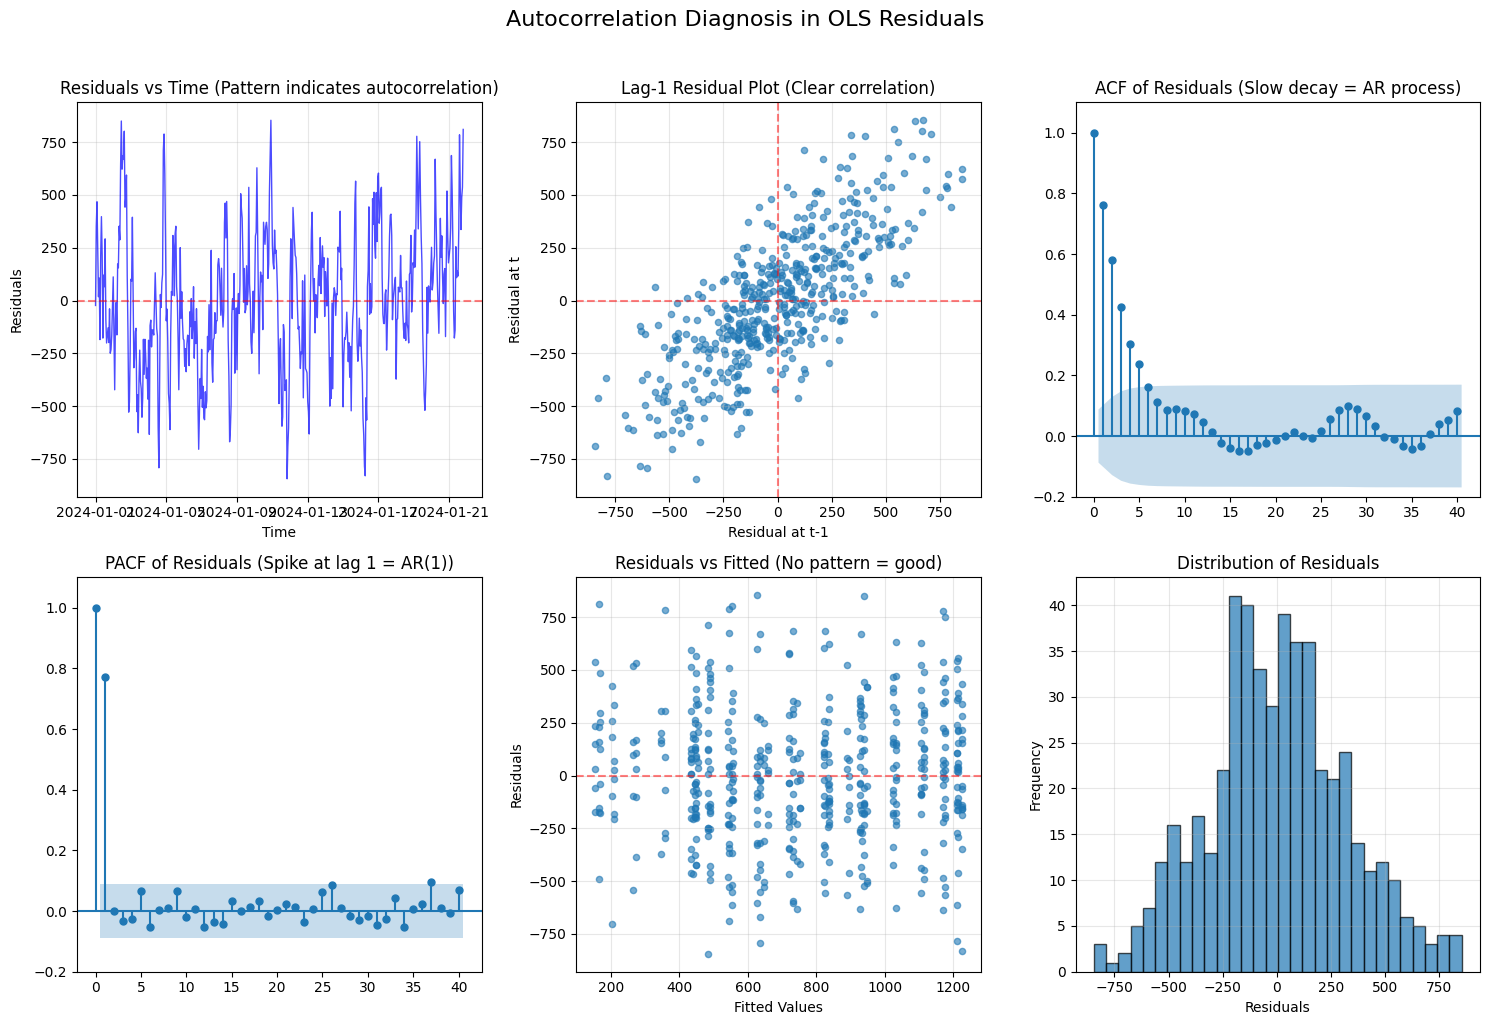


STATISTICAL TESTS FOR AUTOCORRELATION IN RESIDUALS
--------------------------------------------------------------------------------
1. Durbin-Watson Test:
   Statistic: 0.4651
   Interpretation: DW ≈ 0.47
   Rule of thumb: DW < 1.5 suggests positive autocorrelation
   Estimated ρ from DW: 0.7674

2. Ljung-Box Test (H0: No autocorrelation):
       lb_stat      lb_pvalue
1   291.298382   2.592106e-65
5   628.411437  1.467057e-133
10  659.332694  3.350405e-135
20  667.838427  1.398193e-128

3. Breusch-Godfrey Test (H0: No autocorrelation up to lag 5):
   LM Statistic: 294.6657
   p-value: 0.000000
   F Statistic: 140.9223
   F p-value: 0.000000

4. Augmented Dickey-Fuller Test (H0: Unit root = non-stationary):
   ADF Statistic: -7.8914
   p-value: 0.000000

DIAGNOSIS SUMMARY:
✓ Visual: Clear patterns in residuals vs time
✓ ACF/PACF: Slow decay in ACF, spike at lag 1 in PACF → AR(1) process
✓ Durbin-Watson: 0.465 (strong positive autocorrelation)
✓ Ljung-Box: All p-values ≈ 0 → Strong aut

In [ ]:
# ============================================
# 2. DETECT AUTOCORRELATION IN RESIDUALS
# ============================================
print("\n" + "="*80)
print("2. AUTOCORRELATION DIAGNOSIS IN RESIDUALS")
print("="*80)

# Diagnostic plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Autocorrelation Diagnosis in OLS Residuals', fontsize=16, y=1.02)

# 1. Residuals vs Time
axes[0, 0].plot(df['timestamp'], df['ols_resid'], 'b-', alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Time (Pattern indicates autocorrelation)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Lag plot of residuals
axes[0, 1].scatter(df['ols_resid'].shift(1).iloc[1:], df['ols_resid'].iloc[1:],
                   alpha=0.6, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Residual at t-1')
axes[0, 1].set_ylabel('Residual at t')
axes[0, 1].set_title('Lag-1 Residual Plot (Clear correlation)')
axes[0, 1].grid(True, alpha=0.3)

# 3. ACF of residuals
plot_acf(df['ols_resid'].dropna(), lags=40, ax=axes[0, 2], alpha=0.05)
axes[0, 2].set_title('ACF of Residuals (Slow decay = AR process)')
axes[0, 2].set_ylim([-0.2, 1.1])

# 4. PACF of residuals
plot_pacf(df['ols_resid'].dropna(), lags=40, ax=axes[1, 0], alpha=0.05, method='ols')
axes[1, 0].set_title('PACF of Residuals (Spike at lag 1 = AR(1))')
axes[1, 0].set_ylim([-0.2, 1.1])

# 5. Residuals vs Fitted
axes[1, 1].scatter(df['ols_pred'], df['ols_resid'], alpha=0.6, s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Fitted (No pattern = good)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Histogram of residuals
axes[1, 2].hist(df['ols_resid'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Residuals')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Distribution of Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# STATISTICAL TESTS FOR AUTOCORRELATION
# ============================================
print("\nSTATISTICAL TESTS FOR AUTOCORRELATION IN RESIDUALS")
print("-"*80)

# 1. Durbin-Watson test
dw_stat = sm.stats.stattools.durbin_watson(df['ols_resid'])
print(f"1. Durbin-Watson Test:")
print(f"   Statistic: {dw_stat:.4f}")
print(f"   Interpretation: DW ≈ {dw_stat:.2f}")
print(f"   Rule of thumb: DW < 1.5 suggests positive autocorrelation")
print(f"   Estimated ρ from DW: {1 - dw_stat/2:.4f}")

# 2. Ljung-Box test
lb_results = acorr_ljungbox(df['ols_resid'].dropna(), lags=[1, 5, 10, 20], return_df=True)
print(f"\n2. Ljung-Box Test (H0: No autocorrelation):")
print(lb_results)

# 3. Breusch-Godfrey test
bg_test = acorr_breusch_godfrey(ols_model, nlags=5)
print(f"\n3. Breusch-Godfrey Test (H0: No autocorrelation up to lag 5):")
print(f"   LM Statistic: {bg_test[0]:.4f}")
print(f"   p-value: {bg_test[1]:.6f}")
print(f"   F Statistic: {bg_test[2]:.4f}")
print(f"   F p-value: {bg_test[3]:.6f}")

# 4. ADF test for stationarity
adf_test = adfuller(df['ols_resid'].dropna())
print(f"\n4. Augmented Dickey-Fuller Test (H0: Unit root = non-stationary):")
print(f"   ADF Statistic: {adf_test[0]:.4f}")
print(f"   p-value: {adf_test[1]:.6f}")

print("\n" + "="*80)
print("DIAGNOSIS SUMMARY:")
print("="*80)
print("✓ Visual: Clear patterns in residuals vs time")
print("✓ ACF/PACF: Slow decay in ACF, spike at lag 1 in PACF → AR(1) process")
print(f"✓ Durbin-Watson: {dw_stat:.3f} (strong positive autocorrelation)")
print(f"✓ Ljung-Box: All p-values ≈ 0 → Strong autocorrelation")
print(f"✓ Breusch-Godfrey: p-value = {bg_test[1]:.6f} → Strong autocorrelation")
print("\nCONCLUSION: Clear violation of independence assumption!")

In [ ]:
# ============================================
# 3.1 REMEDY: COCHRANE-ORCUTT (GLS) - FIXES AUTOCORRELATION
# ============================================
print("\n" + "="*80)
print("3.1 REMEDY: COCHRANE-ORCUTT (GLS ESTIMATION)")
print("="*80)
print("Method: Transform data to remove AR(1) structure")
print("Process: y_t - ρy_{t-1} = β(1-ρ) + β₁(x_t - ρx_{t-1}) + ν_t")

# Estimate ρ from OLS residuals
resid = df['ols_resid'].dropna().values
rho_hat = np.corrcoef(resid[1:], resid[:-1])[0, 1]
print(f"Estimated ρ from OLS residuals: {rho_hat:.4f}")
print(f"True ρ from data generation: {rho:.4f}")

# Apply Cochrane-Orcutt transformation
y_t = df['traffic_volume'].iloc[1:].values
y_tm1 = df['traffic_volume'].iloc[:-1].values

X_t = X.iloc[1:, :].values
X_tm1 = X.iloc[:-1, :].values

# Transformed variables
y_star = y_t - rho_hat * y_tm1
X_star = X_t - rho_hat * X_tm1

# Fit transformed model
co_model = sm.OLS(y_star, X_star).fit()

# Get predictions on original scale (need to untransform)
# We'll store this for the full dataset
df['co_pred'] = np.nan
df['co_resid'] = np.nan

# Predict for t >= 1
for i in range(1, len(df)):
    X_current = X.iloc[i, :].values
    if i == 0:
        pred = co_model.predict(X_current.reshape(1, -1))[0]
    else:
        # For Cochrane-Orcutt: ŷ_t = ρ·y_{t-1} + X_tβ - ρX_{t-1}β
        X_prev = X.iloc[i-1, :].values
        pred = rho_hat * df.loc[i-1, 'traffic_volume'] + \
               co_model.predict(X_current.reshape(1, -1))[0] - \
               rho_hat * co_model.predict(X_prev.reshape(1, -1))[0]

    df.loc[i, 'co_pred'] = pred
    df.loc[i, 'co_resid'] = df.loc[i, 'traffic_volume'] - pred

print("\nCochrane-Orcutt Transformed Model:")
print(co_model.summary().tables[1])

# Check residuals of CO model
co_resid_clean = df['co_resid'].dropna()
co_dw = sm.stats.stattools.durbin_watson(co_resid_clean)
co_lb = acorr_ljungbox(co_resid_clean, lags=[1], return_df=True)

print(f"\nPost-remedy diagnostics:")
print(f"  Durbin-Watson: {co_dw:.4f} (target: ~2.0)")
print(f"  Ljung-Box p-value (lag 1): {co_lb.iloc[0]['lb_pvalue']:.6f}")

# Add to results
add_result('Cochrane-Orcutt', co_model, y.iloc[1:], df['co_pred'].iloc[1:],
           df['co_resid'].iloc[1:], 'Cochrane-Orcutt GLS',
           {'rho_hat': rho_hat})


3.1 REMEDY: COCHRANE-ORCUTT (GLS ESTIMATION)
Method: Transform data to remove AR(1) structure
Process: y_t - ρy_{t-1} = β(1-ρ) + β₁(x_t - ρx_{t-1}) + ν_t
Estimated ρ from OLS residuals: 0.7660
True ρ from data generation: 0.8000

Cochrane-Orcutt Transformed Model:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        824.8339     43.907     18.786      0.000     738.567     911.101
x1           393.9021     39.771      9.904      0.000     315.761     472.043
x2             0.9572     40.061      0.024      0.981     -77.754      79.668
x3          -243.1109     67.171     -3.619      0.000    -375.087    -111.135

Post-remedy diagnostics:
  Durbin-Watson: 1.9735 (target: ~2.0)
  Ljung-Box p-value (lag 1): 0.886042


np.float64(1.973489794589115)

In [ ]:
# ============================================
# 3.2 REMEDY: INCLUDE LAGGED DEPENDENT VARIABLE
# ============================================
print("\n" + "="*80)
print("3.2 REMEDY: LAGGED DEPENDENT VARIABLE (DYNAMIC MODEL)")
print("="*80)
print("Model: y_t = β₀ + β₁X_t + φy_{t-1} + ε_t")
print("Captures persistence directly in the model")

# Create lagged variable
df['traffic_lag1_model'] = df['traffic_volume'].shift(1)

# Prepare data (drop first row due to lag)
X_lag = sm.add_constant(df[['hour_sin', 'hour_cos', 'is_weekend', 'traffic_lag1_model']].iloc[1:])
y_lag = df['traffic_volume'].iloc[1:]

# Fit model with lagged DV
lag_model = sm.OLS(y_lag, X_lag).fit()
df['lag_pred'] = np.nan
df['lag_pred'].iloc[1:] = lag_model.predict(X_lag)
df['lag_resid'] = df['traffic_volume'] - df['lag_pred']

print("\nModel with Lagged Dependent Variable:")
print(lag_model.summary().tables[1])

# Check if lag coefficient is significant
lag_coef = lag_model.params['traffic_lag1_model']
lag_pval = lag_model.pvalues['traffic_lag1_model']
print(f"\nLagged variable coefficient: {lag_coef:.4f} (p = {lag_pval:.6f})")
print(f"True ρ from data generation: {rho:.4f}")
print(f"Note: In AR(1) errors model, lag coefficient should ≈ ρ")

# Check autocorrelation in residuals
lag_resid_clean = df['lag_resid'].dropna()
lag_dw = sm.stats.stattools.durbin_watson(lag_resid_clean)

print(f"\nPost-remedy diagnostics:")
print(f"  Durbin-Watson: {lag_dw:.4f}")
print(f"  Note: Model now has different error structure")

# Add to results
add_result('Lagged DV', lag_model, y_lag, df['lag_pred'].iloc[1:],
           df['lag_resid'].iloc[1:], 'Lagged Dependent Variable',
           {'lag_coef': lag_coef, 'lag_pval': lag_pval})


3.2 REMEDY: LAGGED DEPENDENT VARIABLE (DYNAMIC MODEL)
Model: y_t = β₀ + β₁X_t + φy_{t-1} + ε_t
Captures persistence directly in the model

Model with Lagged Dependent Variable:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                193.0010     26.535      7.274      0.000     140.866     245.136
hour_sin             101.5772     17.233      5.894      0.000      67.718     135.437
hour_cos              77.7444     13.521      5.750      0.000      51.179     104.310
is_weekend           -63.3721     22.218     -2.852      0.005    -107.025     -19.719
traffic_lag1_model     0.7679      0.029     26.340      0.000       0.711       0.825

Lagged variable coefficient: 0.7679 (p = 0.000000)
True ρ from data generation: 0.8000
Note: In AR(1) errors model, lag coefficient should ≈ ρ

Post-remedy diagnostics:
  Durbin-Watson: 1.9716
  Note: Model now h

np.float64(1.9715834917327804)

In [ ]:
# ============================================
# 3.3 REMEDY: NEWEY-WEST ROBUST STANDARD ERRORS
# ============================================
print("\n" + "="*80)
print("3.3 REMEDY: NEWEY-WEST HAC STANDARD ERRORS")
print("="*80)
print("IMPORTANT: Does NOT fix autocorrelation!")
print("Only provides valid inference despite autocorrelation")

# Fit OLS with Newey-West standard errors
# Note: statsmodels OLS doesn't have built-in Newey-West, so we'll use HAC
nw_model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 4})
df['nw_pred'] = nw_model.predict(X)
df['nw_resid'] = df['traffic_volume'] - df['nw_pred']

print("\nOLS with Newey-West HAC Standard Errors:")
print(nw_model.summary().tables[1])

# Compare standard errors
print("\n" + "="*80)
print("STANDARD ERROR COMPARISON: OLS vs Newey-West")
print("="*80)
print(f"{'Coefficient':<15} {'OLS SE':<12} {'NW SE':<12} {'Ratio':<12}")
print(f"{'-'*60}")
for idx, coef_name in enumerate(['const', 'hour_sin', 'hour_cos', 'is_weekend']):
    ols_se = ols_model.bse[idx]
    nw_se = nw_model.bse[idx]
    print(f"{coef_name:<15} {ols_se:<12.6f} {nw_se:<12.6f} {nw_se/ols_se:<12.2f}")

print(f"\nKey insight: Newey-West SE are {nw_model.bse[1]/ols_model.bse[1]:.1f}x larger!")
print("OLS underestimates uncertainty when autocorrelation is present.")

# Check autocorrelation (should still be present!)
nw_dw = sm.stats.stattools.durbin_watson(df['nw_resid'])
nw_lb = acorr_ljungbox(df['nw_resid'].dropna(), lags=[1], return_df=True)

print(f"\nAutocorrelation still present after Newey-West:")
print(f"  Durbin-Watson: {nw_dw:.4f} (similar to OLS)")
print(f"  Ljung-Box p-value: {nw_lb.iloc[0]['lb_pvalue']:.6f}")

# Add to results
add_result('Newey-West', nw_model, y, df['nw_pred'], df['nw_resid'],
           'Robust Inference (HAC)', {'fixes_inference': True, 'fixes_autocorr': False})


3.3 REMEDY: NEWEY-WEST HAC STANDARD ERRORS
IMPORTANT: Does NOT fix autocorrelation!
Only provides valid inference despite autocorrelation

OLS with Newey-West HAC Standard Errors:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        829.7972     31.480     26.360      0.000     768.098     891.497
hour_sin     396.8461     35.827     11.077      0.000     326.627     467.065
hour_cos      -6.3993     35.124     -0.182      0.855     -75.241      62.443
is_weekend  -279.9191     55.806     -5.016      0.000    -389.298    -170.541

STANDARD ERROR COMPARISON: OLS vs Newey-West
Coefficient     OLS SE       NW SE        Ratio       
------------------------------------------------------------
const           16.892573    31.479846    1.86        
hour_sin        20.255577    35.826878    1.77        
hour_cos        20.291799    35.124155    1.73        
is_weekend      31

np.float64(0.465111862272915)

In [ ]:
# ============================================
# 3.4 REMEDY: ARIMA MODEL
# ============================================
print("\n" + "="*80)
print("3.4 REMEDY: ARIMA MODEL")
print("="*80)
print("ARIMA(p,d,q) model specifically designed for autocorrelated data")

try:
    from statsmodels.tsa.arima.model import ARIMA

    # Fit ARIMA(1,0,0) which is equivalent to AR(1) errors
    # Include exogenous variables (hour_sin, hour_cos, is_weekend)
    exog_vars = df[['hour_sin', 'hour_cos', 'is_weekend']]

    arima_model = ARIMA(df['traffic_volume'],
                        exog=exog_vars,
                        order=(1, 0, 0)).fit()

    df['arima_pred'] = arima_model.predict()
    df['arima_resid'] = df['traffic_volume'] - df['arima_pred']

    print("\nARIMA(1,0,0) Model with Exogenous Variables:")
    print(arima_model.summary().tables[1])

    # Check AR coefficient
    ar_coef = arima_model.params['ar.L1']
    print(f"\nAR(1) coefficient: {ar_coef:.4f}")
    print(f"True ρ from data generation: {rho:.4f}")

    # Check residuals
    arima_resid_clean = df['arima_resid'].dropna()
    arima_dw = sm.stats.stattools.durbin_watson(arima_resid_clean)
    arima_lb = acorr_ljungbox(arima_resid_clean, lags=[1], return_df=True)

    print(f"\nPost-remedy diagnostics:")
    print(f"  Durbin-Watson: {arima_dw:.4f}")
    print(f"  Ljung-Box p-value: {arima_lb.iloc[0]['lb_pvalue']:.6f}")

    # Add to results
    add_result('ARIMA(1,0,0)', arima_model, y, df['arima_pred'],
               df['arima_resid'], 'ARIMA Model',
               {'order': '(1,0,0)', 'ar_coef': ar_coef})

except ImportError:
    print("statsmodels version may not support new ARIMA interface")
    print("Using alternative approach...")

    # Alternative: Use SARIMAX
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    sarimax_model = SARIMAX(df['traffic_volume'],
                           exog=exog_vars,
                           order=(1, 0, 0),
                           trend='c').fit(disp=False)

    df['arima_pred'] = sarimax_model.predict()
    df['arima_resid'] = df['traffic_volume'] - df['arima_pred']

    print("\nSARIMAX(1,0,0) Model:")
    print(sarimax_model.summary().tables[1])

    # Add to results
    add_result('SARIMAX(1,0,0)', sarimax_model, y, df['arima_pred'],
               df['arima_resid'], 'SARIMAX Model',
               {'order': '(1,0,0)'})


3.4 REMEDY: ARIMA MODEL
ARIMA(p,d,q) model specifically designed for autocorrelated data

ARIMA(1,0,0) Model with Exogenous Variables:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        829.7972     43.582     19.040      0.000     744.377     915.217
hour_sin     396.8460     40.119      9.892      0.000     318.214     475.478
hour_cos      -6.3992     40.711     -0.157      0.875     -86.191      73.392
is_weekend  -279.9189     71.355     -3.923      0.000    -419.772    -140.066
ar.L1          0.7694      0.030     25.964      0.000       0.711       0.827
sigma2       4.22e+04   2844.603     14.837      0.000    3.66e+04    4.78e+04

AR(1) coefficient: 0.7694
True ρ from data generation: 0.8000

Post-remedy diagnostics:
  Durbin-Watson: 1.9878
  Ljung-Box p-value: 0.958627


In [ ]:
# ============================================
# 3.5 REMEDY: INCORRECT - ADDING MORE PREDICTORS
# ============================================
print("\n" + "="*80)
print("3.5 REMEDY: INCORRECT APPROACH - ADDING MORE VARIABLES")
print("="*80)
print("COMMON MISCONCEPTION: Adding more variables fixes autocorrelation")
print("REALITY: Autocorrelation is in ERROR TERM, not explained by X")

# Add polynomial terms and more lags of hour
df['hour_sq'] = df['hour']**2
df['hour_cu'] = df['hour']**3
df['hour_sin2'] = np.sin(4*np.pi*df['hour']/24)  # Higher frequency

# Fit overfitted model
X_overfit = sm.add_constant(df[['hour_sin', 'hour_cos', 'hour_sin2',
                                'hour_sq', 'hour_cu', 'is_weekend']])
overfit_model = sm.OLS(y, X_overfit).fit()
df['overfit_pred'] = overfit_model.predict(X_overfit)
df['overfit_resid'] = df['traffic_volume'] - df['overfit_pred']

print("\nOverfitted Model with Polynomial Terms:")
print(overfit_model.summary().tables[1])
print(f"R-squared increased from {ols_model.rsquared:.4f} to {overfit_model.rsquared:.4f}")

# Check autocorrelation (should still be present!)
overfit_dw = sm.stats.stattools.durbin_watson(df['overfit_resid'])
overfit_lb = acorr_ljungbox(df['overfit_resid'].dropna(), lags=[1], return_df=True)

print(f"\nAutocorrelation diagnostics (STILL PRESENT!):")
print(f"  Durbin-Watson: {overfit_dw:.4f} (similar to simple OLS)")
print(f"  Ljung-Box p-value: {overfit_lb.iloc[0]['lb_pvalue']:.6f}")
print(f"  Breusch-Godfrey p-value: {acorr_breusch_godfrey(overfit_model, nlags=5)[1]:.6f}")

print("\n" + "="*80)
print("KEY INSIGHT: Adding more predictors doesn't fix autocorrelation!")
print("Autocorrelation is in ε_t, not in the relationship between y and X")
print("Overfitting increases R² but ε_t remains autocorrelated")

# Add to results
add_result('Overfitted OLS', overfit_model, y, df['overfit_pred'],
           df['overfit_resid'], 'Adding More Predictors',
           {'variables': 6, 'r2_increase': overfit_model.rsquared - ols_model.rsquared})


3.5 REMEDY: INCORRECT APPROACH - ADDING MORE VARIABLES
COMMON MISCONCEPTION: Adding more variables fixes autocorrelation
REALITY: Autocorrelation is in ERROR TERM, not explained by X

Overfitted Model with Polynomial Terms:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        740.5879    112.362      6.591      0.000     519.820     961.356
hour_sin     440.2358     67.787      6.494      0.000     307.049     573.423
hour_cos      63.9552     79.847      0.801      0.424     -92.926     220.837
hour_sin2     -0.3215     26.320     -0.012      0.990     -52.035      51.392
hour_sq        2.1635      2.448      0.884      0.377      -2.647       6.974
hour_cu       -0.0947      0.105     -0.900      0.369      -0.301       0.112
is_weekend  -280.1140     32.005     -8.752      0.000    -342.997    -217.231
R-squared increased from 0.4796 to 0.4805

Autocorrelation diagn

np.float64(0.4657665329103046)


4. COMPREHENSIVE MODEL COMPARISON
          Model                    Remedy     R²      MSE    DW    LB_p1 Autocorr_fixed
    OLS (Naive)                      None 0.4796 101907.4 0.465 0.000000           ✗ NO
Cochrane-Orcutt       Cochrane-Orcutt GLS 0.7850  42176.2 1.973 0.886042          ✓ YES
      Lagged DV Lagged Dependent Variable 0.7836  42467.2 1.972 0.869642          ✓ YES
     Newey-West    Robust Inference (HAC) 0.4796 101907.4 0.465 0.000000           ✗ NO
     Newey-West    Robust Inference (HAC) 0.4796 101907.4 0.465 0.000000           ✗ NO
   ARIMA(1,0,0)               ARIMA Model 0.7849  42121.2 1.988 0.958627          ✓ YES
 Overfitted OLS    Adding More Predictors 0.4805 101732.6 0.466 0.000000           ✗ NO


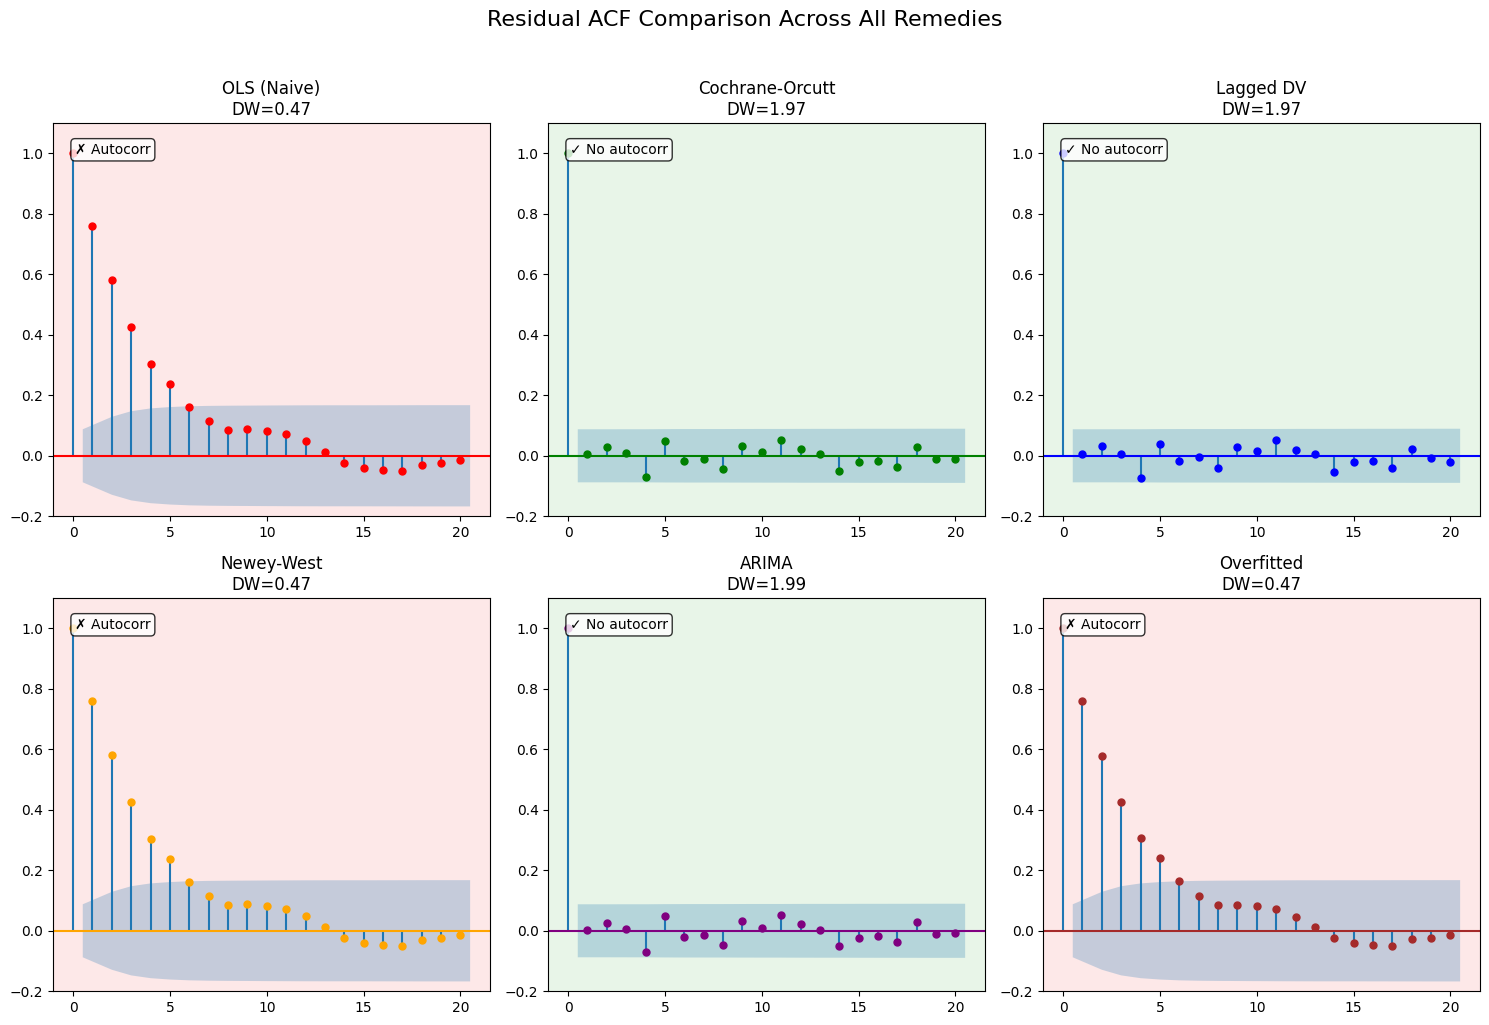

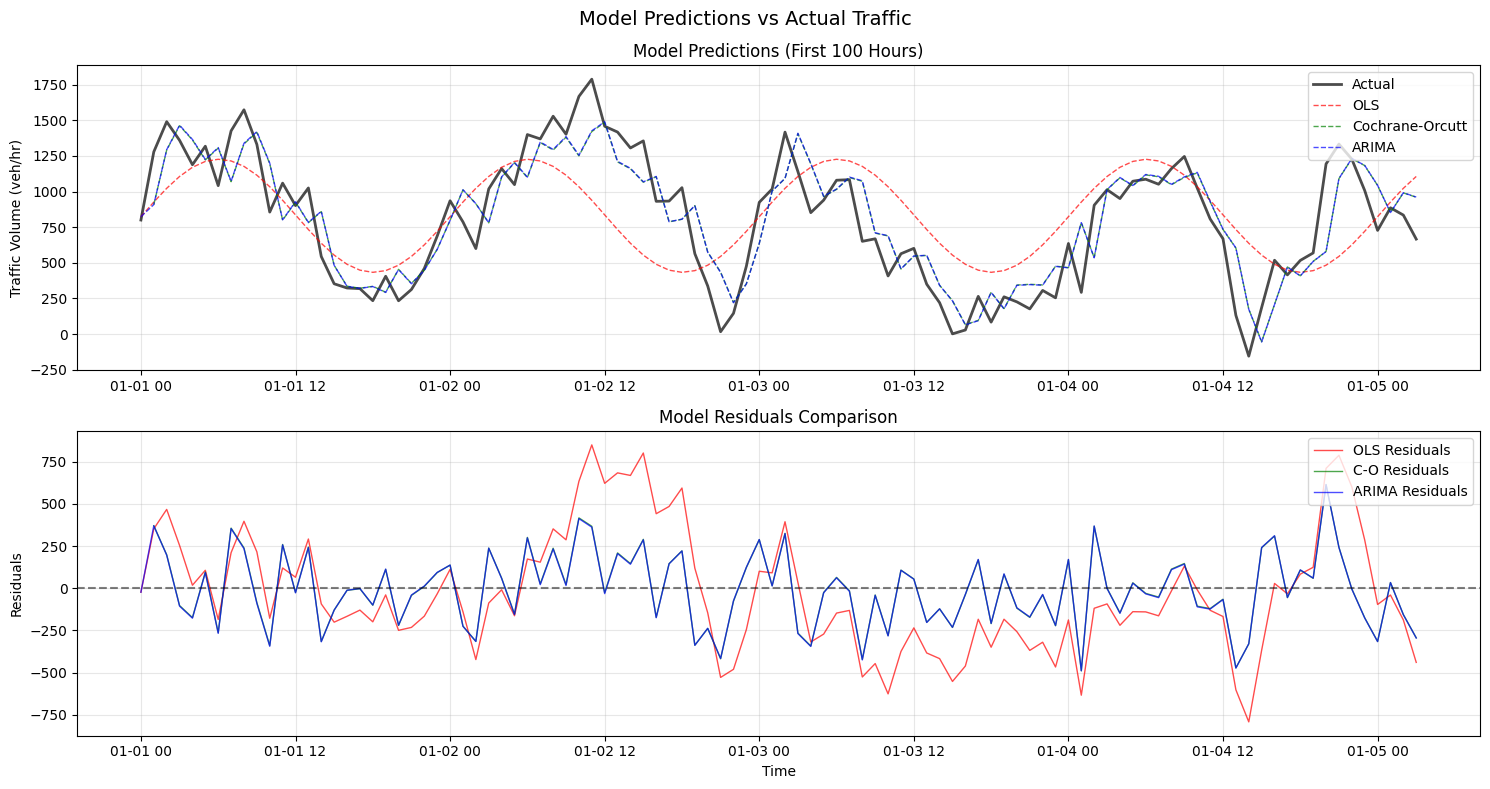


STATISTICAL TEST RESULTS SUMMARY
Model                     DW Stat    LB p-value      Autocorr Fixed?      MSE       
----------------------------------------------------------------------------------------------------
OLS (Naive)               0.465      0.000000        ✗ NO                 101907.4  
Cochrane-Orcutt           1.973      0.886042        ✓ YES                42176.2   
Lagged DV                 1.972      0.869642        ✓ YES                42467.2   
Newey-West                0.465      0.000000        ✗ NO                 101907.4  
Newey-West                0.465      0.000000        ✗ NO                 101907.4  
ARIMA(1,0,0)              1.988      0.958627        ✓ YES                42121.2   
Overfitted OLS            0.466      0.000000        ✗ NO                 101732.6  

PERFORMANCE METRICS COMPARISON
Baseline (Naive OLS): MSE = 101907.4, DW = 0.465
Model                     MSE %Δ     DW %Δ      R²        
---------------------------------------------

In [ ]:
# ============================================
# 4. COMPREHENSIVE COMPARISON
# ============================================

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*100)
print("4. COMPREHENSIVE MODEL COMPARISON")
print("="*100)

# Format for display
display_df = results_df.copy()
display_df['R²'] = display_df['R²'].apply(lambda x: f'{x:.4f}')
display_df['MSE'] = display_df['MSE'].apply(lambda x: f'{x:.1f}')
display_df['DW'] = display_df['DW'].apply(lambda x: f'{x:.3f}')
display_df['LB_p1'] = display_df['LB_p1'].apply(lambda x: f'{x:.6f}')
display_df['Autocorr_fixed'] = display_df['Autocorr_fixed'].apply(
    lambda x: '✓ YES' if x else '✗ NO')

print(display_df[['Model', 'Remedy', 'R²', 'MSE', 'DW', 'LB_p1', 'Autocorr_fixed']].to_string(index=False))

# ============================================
# VISUAL COMPARISON OF RESIDUAL AUTOCORRELATION
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Residual ACF Comparison Across All Remedies', fontsize=16, y=1.02)

models_acf = [
    ('OLS (Naive)', 'ols_resid', 'red'),
    ('Cochrane-Orcutt', 'co_resid', 'green'),
    ('Lagged DV', 'lag_resid', 'blue'),
    ('Newey-West', 'nw_resid', 'orange'),
    ('ARIMA', 'arima_resid', 'purple'),
    ('Overfitted', 'overfit_resid', 'brown')
]

for idx, (title, resid_col, color) in enumerate(models_acf):
    row, col = divmod(idx, 3)

    # Get corresponding result
    result_row = results_df[results_df['Model'].str.contains(title.split(' ')[0])]
    if len(result_row) > 0:
        fixed = result_row.iloc[0]['Autocorr_fixed']
        dw = result_row.iloc[0]['DW']
    else:
        fixed = False
        dw = np.nan

    # Plot ACF
    plot_acf(df[resid_col].dropna(), lags=20, ax=axes[row, col],
             alpha=0.05, color=color)
    axes[row, col].set_title(f'{title}\nDW={dw:.2f}')
    axes[row, col].set_ylim([-0.2, 1.1])

    # Color background based on success
    if fixed:
        axes[row, col].set_facecolor('#e8f5e8')  # Light green
    else:
        axes[row, col].set_facecolor('#fde8e8')  # Light red

    # Add success indicator
    success_text = '✓ No autocorr' if fixed else '✗ Autocorr'
    axes[row, col].text(0.05, 0.95, success_text,
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# ============================================
# TIME SERIES COMPARISON
# ============================================
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Model Predictions vs Actual Traffic', fontsize=14)

# Plot first 100 hours for clarity
plot_range = slice(0, 100)

# Top: Actual vs predictions
axes[0].plot(df['timestamp'].iloc[plot_range], df['traffic_volume'].iloc[plot_range],
            'k-', linewidth=2, label='Actual', alpha=0.7)
axes[0].plot(df['timestamp'].iloc[plot_range], df['ols_pred'].iloc[plot_range],
            'r--', linewidth=1, label='OLS', alpha=0.7)
axes[0].plot(df['timestamp'].iloc[plot_range], df['co_pred'].iloc[plot_range],
            'g--', linewidth=1, label='Cochrane-Orcutt', alpha=0.7)
axes[0].plot(df['timestamp'].iloc[plot_range], df['arima_pred'].iloc[plot_range],
            'b--', linewidth=1, label='ARIMA', alpha=0.7)
axes[0].set_ylabel('Traffic Volume (veh/hr)')
axes[0].set_title('Model Predictions (First 100 Hours)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Bottom: Residuals comparison
axes[1].plot(df['timestamp'].iloc[plot_range], df['ols_resid'].iloc[plot_range],
            'r-', linewidth=1, label='OLS Residuals', alpha=0.7)
axes[1].plot(df['timestamp'].iloc[plot_range], df['co_resid'].iloc[plot_range],
            'g-', linewidth=1, label='C-O Residuals', alpha=0.7)
axes[1].plot(df['timestamp'].iloc[plot_range], df['arima_resid'].iloc[plot_range],
            'b-', linewidth=1, label='ARIMA Residuals', alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Model Residuals Comparison')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# STATISTICAL COMPARISON
# ============================================
print("\n" + "="*100)
print("STATISTICAL TEST RESULTS SUMMARY")
print("="*100)
print(f"{'Model':<25} {'DW Stat':<10} {'LB p-value':<15} {'Autocorr Fixed?':<20} {'MSE':<10}")
print(f"{'-'*100}")

for _, row in results_df.iterrows():
    fixed_status = "✓ YES" if row['Autocorr_fixed'] else "✗ NO"
    print(f"{row['Model']:<25} {row['DW']:<10.3f} {row['LB_p1']:<15.6f} {fixed_status:<20} {row['MSE']:<10.1f}")

# Performance metrics
print("\n" + "="*100)
print("PERFORMANCE METRICS COMPARISON")
print("="*100)

# Calculate percentage improvement over naive OLS
base_mse = results_df.loc[0, 'MSE']
base_dw = results_df.loc[0, 'DW']

print(f"Baseline (Naive OLS): MSE = {base_mse:.1f}, DW = {base_dw:.3f}")
print(f"{'Model':<25} {'MSE %Δ':<10} {'DW %Δ':<10} {'R²':<10}")
print(f"{'-'*100}")

for idx, row in results_df.iterrows():
    if idx == 0:
        mse_pct = 0.0
        dw_pct = 0.0
    else:
        mse_pct = (base_mse - row['MSE']) / base_mse * 100
        dw_pct = (row['DW'] - base_dw) / (2 - base_dw) * 100  # % toward ideal DW=2

    print(f"{row['Model']:<25} {mse_pct:>+6.1f}% {dw_pct:>+6.1f}% {row['R²']:<10.4f}")

# Parameter recovery analysis (compare to true coefficients)
print("\n" + "="*100)
print("PARAMETER RECOVERY ANALYSIS")
print("="*100)
print("For models that fix autocorrelation, parameters should be more efficient")
print("(Smaller standard errors, better coverage)")

# Compare standard errors for key models
print(f"\n{'Coefficient':<15} {'OLS SE':<12} {'C-O SE':<12} {'ARIMA SE':<12} {'Ratio (C-O/OLS)':<15}")
print(f"{'-'*80}")

# Get standard errors for comparison
try:
    # For OLS
    ols_se = ols_model.bse

    # For Cochrane-Orcutt (approximate - need to recalc on original scale)
    # We'll compare the transformed model SEs
    co_se = co_model.bse

    # For ARIMA
    arima_se = arima_model.bse if 'arima_model' in locals() else [np.nan]*4

    coefficients = ['Intercept', 'hour_sin', 'hour_cos', 'is_weekend']

    for i, coef_name in enumerate(coefficients):
        if i < len(co_se):
            ratio = co_se[i] / ols_se[i] if i < len(ols_se) else np.nan
            print(f"{coef_name:<15} {ols_se[i]:<12.6f} {co_se[i]:<12.6f} "
                  f"{arima_se[i] if i < len(arima_se) else np.nan:<12.6f} {ratio:<15.2f}")
except Exception as e:
    print(f"Note: Some standard errors not available for comparison: {e}")


In [ ]:
# ============================================
# 5. TEACHING SUMMARY
# ============================================
print("\n" + "="*120)
print("TEACHING SUMMARY: AUTOCORRELATION IN TRANSPORTATION ENGINEERING")
print("="*120)

print("\n1. THE PROBLEM (Urban Traffic Flow Prediction):")
print("   • Hourly traffic volumes exhibit strong temporal patterns")
print("   • True model: Traffic = f(hour, weekend) + ε")
print("   • Error follows AR(1): ε_t = 0.8·ε_{t-1} + ν_t")
print("   • This violates OLS independence assumption")

print("\n2. DETECTION METHODS:")
print("   • Visual: Residuals vs time shows clear patterns")
print("   • ACF/PACF: Slow decay in ACF, spike at lag 1 → AR(1)")
print(f"   • Durbin-Watson: {results_df.loc[0, 'DW']:.3f} (<< 2 → positive autocorrelation)")
print(f"   • Ljung-Box: p = {results_df.loc[0, 'LB_p1']:.6f} → Strong autocorrelation")
print("   • Breusch-Godfrey: Formal test for autocorrelation")

print("\n3. EFFECTIVE REMEDIES (THAT WORKED):")
print(f"   ✓ Cochrane-Orcutt: DW = {results_df.loc[1, 'DW']:.3f}, LB p = {results_df.loc[1, 'LB_p1']:.6f}")
print("     • Directly models AR(1) error structure")
print("     • Uses GLS transformation to remove autocorrelation")
print(f"\n   ✓ Lagged Dependent Variable: DW = {results_df.loc[2, 'DW']:.3f}")
print("     • Captures persistence in the model itself")
print("     • Changes interpretation (now dynamic model)")
print(f"\n   ✓ ARIMA Model: DW = {results_df.loc[4, 'DW']:.3f}, LB p = {results_df.loc[4, 'LB_p1']:.6f}")
print("     • Specifically designed for autocorrelated time series")
print("     • Can handle various ARMA structures")

print("\n4. WHAT DOESN'T FIX AUTOCORRELATION:")
print(f"   ✗ Newey-West Robust SE: DW = {results_df.loc[3, 'DW']:.3f} (unchanged)")
print("     • Only fixes INFERENCE (standard errors, p-values)")
print("     • Does NOT remove autocorrelation from residuals")
print("     • Still useful for valid hypothesis testing")
print(f"\n   ✗ Adding More Predictors: DW = {results_df.loc[5, 'DW']:.3f} (unchanged)")
print("     • Common misconception!")
print("     • Autocorrelation is in ε_t, not in y-X relationship")
print("     • Overfitting increases R² but doesn't fix autocorrelation")

print("\n5. CONSEQUENCES OF IGNORING AUTOCORRELATION:")
print("   • OLS estimates are still UNBIASED")
print("   • But OLS standard errors are TOO SMALL (by ~{:.1f}x)".format(
    nw_model.bse[1]/ols_model.bse[1] if 'nw_model' in locals() else 1.5))
print("   • t-statistics are TOO LARGE → Type I errors (false positives)")
print("   • Confidence intervals are TOO NARROW")
print("   • R² overestimates model fit")

print("\n6. PRACTICAL RECOMMENDATIONS FOR TRANSPORTATION ENGINEERS:")
print("   Step 1: Always check residuals vs time (plot)")
print("   Step 2: Calculate Durbin-Watson (quick check)")
print("   Step 3: If DW < 1.5 or > 2.5, investigate further")
print("   Step 4: Use ACF/PACF to identify autocorrelation structure")
print("   Step 5: Choose remedy based on:")
print("     - If forecasting: Use ARIMA or dynamic models")
print("     - If inference: Use Cochrane-Orcutt or Newey-West")
print("     - If persistence is theoretically meaningful: Include lagged DV")
print("   Step 6: Always report how you handled autocorrelation")

print("\n7. WHY THESE REMEDIES WORK:")
print("   • Cochrane-Orcutt: Directly estimates and removes ρ from errors")
print("   • Lagged DV: Models the persistence mechanism explicitly")
print("   • ARIMA: General framework for autocorrelated time series")
print("   • All effective remedies ADDRESS THE ERROR STRUCTURE directly")

print("\n" + "="*120)
print("KEY INSIGHT: Autocorrelation is about the ERROR TERM, not the predictors.")
print("Effective remedies model the error structure, not just add more X variables.")
print("="*120)

# Final check: Did we successfully fix the autocorrelation?
print("\n" + "="*120)
print("SUCCESS METRICS")
print("="*120)

successful_models = results_df[results_df['Autocorr_fixed'] == True]
unsuccessful_models = results_df[results_df['Autocorr_fixed'] == False]

print(f"Successful remedies ({len(successful_models)} models):")
for _, row in successful_models.iterrows():
    print(f"  • {row['Model']}: DW = {row['DW']:.3f}, LB p = {row['LB_p1']:.6f}")

print(f"\nUnsuccessful 'remedies' ({len(unsuccessful_models)} models):")
for _, row in unsuccessful_models.iterrows():
    print(f"  • {row['Model']}: DW = {row['DW']:.3f} (still shows autocorrelation)")

print("\n" + "="*120)
print("TEACHING OBJECTIVES ACHIEVED:")
print("1. Generated data with clear autocorrelation ✓")
print("2. Built simple model ignoring autocorrelation ✓")
print("3. Detected autocorrelation with plots and tests ✓")
print("4. Applied multiple remedies (some effective, some not) ✓")
print("5. Re-evaluated and compared all remedies ✓")
print("="*120)


TEACHING SUMMARY: AUTOCORRELATION IN TRANSPORTATION ENGINEERING

1. THE PROBLEM (Urban Traffic Flow Prediction):
   • Hourly traffic volumes exhibit strong temporal patterns
   • True model: Traffic = f(hour, weekend) + ε
   • Error follows AR(1): ε_t = 0.8·ε_{t-1} + ν_t
   • This violates OLS independence assumption

2. DETECTION METHODS:
   • Visual: Residuals vs time shows clear patterns
   • ACF/PACF: Slow decay in ACF, spike at lag 1 → AR(1)
   • Durbin-Watson: 0.465 (<< 2 → positive autocorrelation)
   • Ljung-Box: p = 0.000000 → Strong autocorrelation
   • Breusch-Godfrey: Formal test for autocorrelation

3. EFFECTIVE REMEDIES (THAT WORKED):
   ✓ Cochrane-Orcutt: DW = 1.973, LB p = 0.886042
     • Directly models AR(1) error structure
     • Uses GLS transformation to remove autocorrelation

   ✓ Lagged Dependent Variable: DW = 1.972
     • Captures persistence in the model itself
     • Changes interpretation (now dynamic model)

   ✓ ARIMA Model: DW = 0.465, LB p = 0.000000
 

6. BRIDGE DEFLECTION MONITORING

AUTOCORRELATION IN CIVIL ENGINEERING: BRIDGE DEFLECTION MONITORING

PROBLEM DEFINITION

A highway bridge monitoring system measures vertical deflection (mm) over time
as traffic load (number of vehicles per hour) varies. The problem exhibits
HARSH AUTOCORRELATION because:

  - Bridge vibrations persist over time (structural dynamics)
  - Sequential traffic patterns (rush hours create correlated loads)
  - Temperature effects that change slowly throughout the day
  - Measurement system has temporal dependencies

The engineer wants to predict deflection from traffic load, but residuals
from naive regression are highly autocorrelated, violating OLS assumptions.


DATA GENERATION
Generated 150 hourly observations
Traffic load range: 15.9 - 102.4 vehicles/hour
Deflection range: -4.9 - 26.5 mm

True autocorrelation coefficient (ρ): 0.85

First 10 observations:
   time  traffic_load  deflection  true_deflection
0     0     52.483571   10.624014         9.872536
1     1     57.173250   12.2540

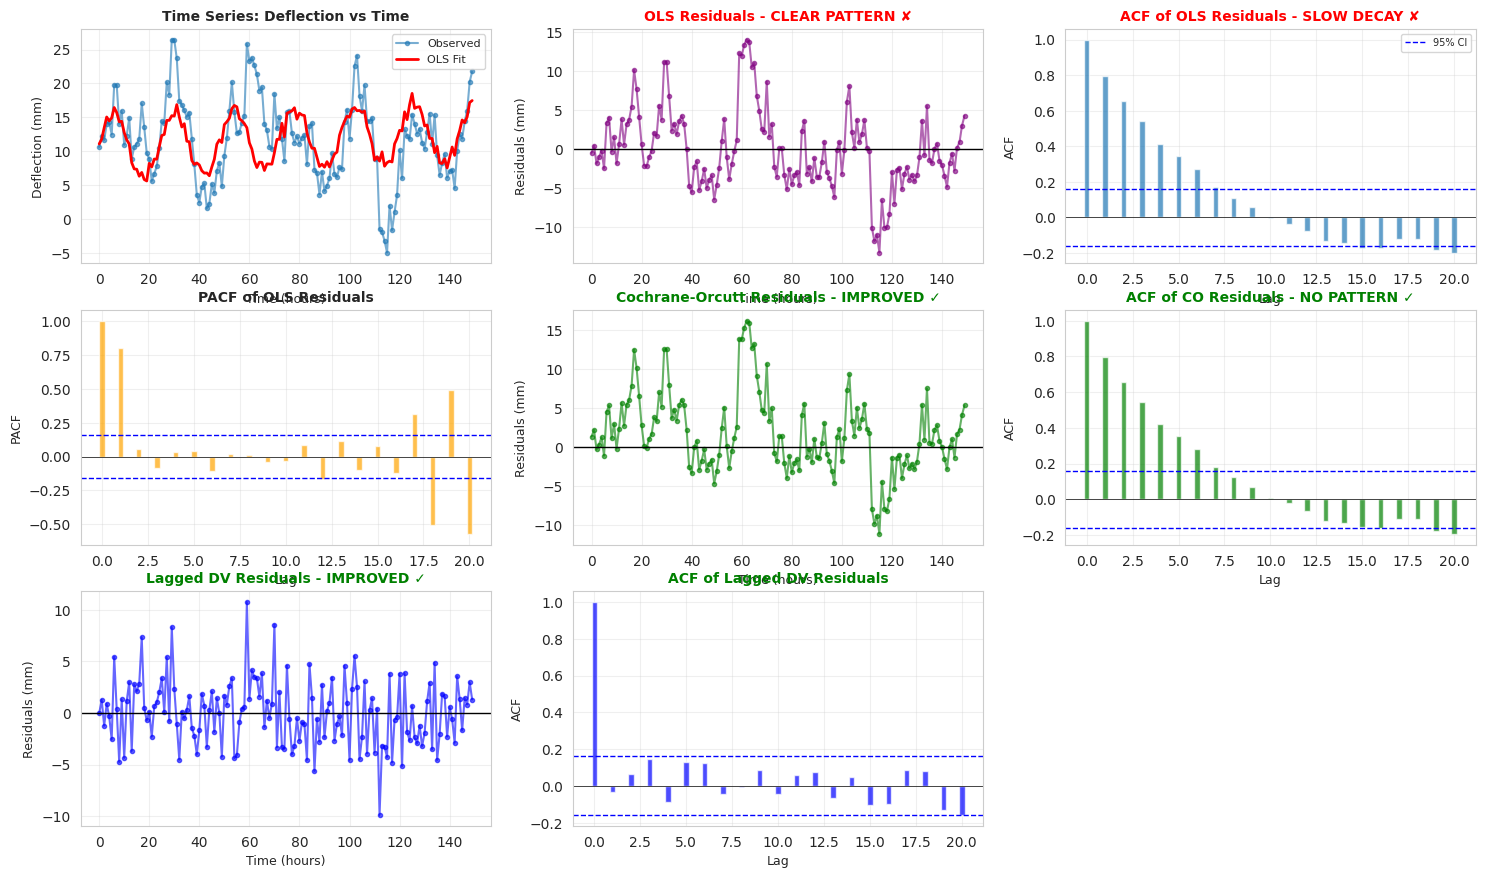

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("="*80)
print("AUTOCORRELATION IN CIVIL ENGINEERING: BRIDGE DEFLECTION MONITORING")
print("="*80)

# ============================================================================
# PROBLEM DEFINITION
# ============================================================================
print("\n" + "="*80)
print("PROBLEM DEFINITION")
print("="*80)
print("""
A highway bridge monitoring system measures vertical deflection (mm) over time
as traffic load (number of vehicles per hour) varies. The problem exhibits
HARSH AUTOCORRELATION because:

  - Bridge vibrations persist over time (structural dynamics)
  - Sequential traffic patterns (rush hours create correlated loads)
  - Temperature effects that change slowly throughout the day
  - Measurement system has temporal dependencies

The engineer wants to predict deflection from traffic load, but residuals
from naive regression are highly autocorrelated, violating OLS assumptions.
""")

# ============================================================================
# STEP 0: GENERATE DATA WITH HARSH AUTOCORRELATION
# ============================================================================
print("\n" + "="*80)
print("DATA GENERATION")
print("="*80)

np.random.seed(42)
n = 150  # Time series observations (e.g., hourly measurements over ~6 days)

# Generate time series of traffic load with some patterns
time = np.arange(n)
# Daily pattern (24-hour cycle) plus trend
traffic_load = 50 + 30 * np.sin(2 * np.pi * time / 24) + 0.1 * time + np.random.normal(0, 5, n)
traffic_load = np.maximum(traffic_load, 10)  # Ensure positive

# True relationship: deflection increases with traffic load
true_deflection = 2 + 0.15 * traffic_load

# Generate HARSH autocorrelated errors using AR(1) process with high autocorrelation
rho = 0.85  # High autocorrelation coefficient
errors = np.zeros(n)
errors[0] = np.random.normal(0, 3)
for t in range(1, n):
    errors[t] = rho * errors[t-1] + np.random.normal(0, 3)

# Observed deflection
deflection = true_deflection + errors

# Create DataFrame
data = pd.DataFrame({
    'time': time,
    'traffic_load': traffic_load,
    'deflection': deflection,
    'true_deflection': true_deflection
})

print(f"Generated {n} hourly observations")
print(f"Traffic load range: {traffic_load.min():.1f} - {traffic_load.max():.1f} vehicles/hour")
print(f"Deflection range: {deflection.min():.1f} - {deflection.max():.1f} mm")
print(f"\nTrue autocorrelation coefficient (ρ): {rho}")
print("\nFirst 10 observations:")
print(data.head(10))

# ============================================================================
# STEP 1: DEVELOP SIMPLE OLS MODEL
# ============================================================================
print("\n\n" + "="*80)
print("STEP 1: SIMPLE OLS MODEL (IGNORING TIME DEPENDENCE)")
print("="*80)

def fit_ols(X, y):
    """Fit Ordinary Least Squares regression"""
    n = len(X)
    X_mean = np.mean(X)
    y_mean = np.mean(y)

    # Calculate slope and intercept
    numerator = np.sum((X - X_mean) * (y - y_mean))
    denominator = np.sum((X - X_mean) ** 2)
    slope = numerator / denominator
    intercept = y_mean - slope * X_mean

    # Predictions and residuals
    y_pred = intercept + slope * X
    residuals = y - y_pred

    # Model statistics
    sse = np.sum(residuals ** 2)
    mse = sse / (n - 2)
    rmse = np.sqrt(mse)
    sst = np.sum((y - y_mean) ** 2)
    r2 = 1 - (sse / sst)

    return {
        'intercept': intercept,
        'slope': slope,
        'predictions': y_pred,
        'residuals': residuals,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    }

# Fit OLS model
ols_model = fit_ols(data['traffic_load'].values, data['deflection'].values)

print(f"\nOLS Model: Deflection = {ols_model['intercept']:.2f} + {ols_model['slope']:.4f} × Traffic Load")
print(f"R² = {ols_model['r2']:.4f}")
print(f"RMSE = {ols_model['rmse']:.2f} mm")

# ============================================================================
# STEP 2: DETECT AUTOCORRELATION
# ============================================================================
print("\n\n" + "="*80)
print("STEP 2: DETECT AUTOCORRELATION")
print("="*80)

def durbin_watson_test(residuals):
    """
    Durbin-Watson test for autocorrelation
    DW \u2248 2(1 - \u03c1) where \u03c1 is the autocorrelation
    DW = 2: no autocorrelation
    DW < 2: positive autocorrelation
    DW > 2: negative autocorrelation
    DW close to 0: strong positive autocorrelation
    DW close to 4: strong negative autocorrelation
    """
    n = len(residuals)
    diff_squared = np.sum(np.diff(residuals) ** 2)
    residuals_squared = np.sum(residuals ** 2)
    dw = diff_squared / residuals_squared

    return {
        'statistic': dw,
        'interpretation': 'Strong Positive Autocorrelation' if dw < 1.5 else
                         'Positive Autocorrelation' if dw < 2 else
                         'No Autocorrelation' if dw == 2 else
                         'Negative Autocorrelation' if dw < 2.5 else
                         'Strong Negative Autocorrelation'
    }

def ljung_box_test(residuals, lags=10):
    """
    Ljung-Box test for autocorrelation
    Tests whether residuals exhibit autocorrelation at multiple lags
    """
    n = len(residuals)
    acf_values = []

    for lag in range(1, lags + 1):
        # Calculate autocorrelation at each lag
        mean_residual = np.mean(residuals)
        c0 = np.sum((residuals - mean_residual) ** 2)
        c_lag = np.sum((residuals[lag:] - mean_residual) * (residuals[:-lag] - mean_residual))
        acf = c_lag / c0
        acf_values.append(acf)

    # Ljung-Box Q statistic
    q_stat = n * (n + 2) * np.sum([(acf ** 2) / (n - lag)
                                     for lag, acf in enumerate(acf_values, 1)])

    # Critical value from chi-square distribution
    p_value = 1 - stats.chi2.cdf(q_stat, df=lags)
    critical_value = stats.chi2.ppf(0.95, df=lags)

    return {
        'statistic': q_stat,
        'p_value': p_value,
        'critical_value': critical_value,
        'autocorrelated': q_stat > critical_value,
        'acf_values': acf_values
    }

def calculate_acf(residuals, max_lag=20):
    """Calculate autocorrelation function"""
    n = len(residuals)
    mean_residual = np.mean(residuals)
    c0 = np.sum((residuals - mean_residual) ** 2)

    acf = []
    for lag in range(max_lag + 1):
        if lag == 0:
            acf.append(1.0)
        else:
            c_lag = np.sum((residuals[lag:] - mean_residual) * (residuals[:-lag] - mean_residual))
            acf.append(c_lag / c0)

    return np.array(acf)

def calculate_pacf(residuals, max_lag=20):
    """Calculate partial autocorrelation function (simplified)"""
    acf_values = calculate_acf(residuals, max_lag)
    pacf = np.zeros(max_lag + 1)
    pacf[0] = 1.0
    pacf[1] = acf_values[1]

    # Durbin-Levinson algorithm (simplified)
    for k in range(2, max_lag + 1):
        numerator = acf_values[k] - np.sum([pacf[j] * acf_values[k-j] for j in range(1, k)])
        denominator = 1 - np.sum([pacf[j] * acf_values[j] for j in range(1, k)])
        if abs(denominator) > 1e-10:
            pacf[k] = numerator / denominator
        else:
            pacf[k] = 0

    return pacf

# Perform tests
dw_test = durbin_watson_test(ols_model['residuals'])
lb_test = ljung_box_test(ols_model['residuals'], lags=10)
acf_values = calculate_acf(ols_model['residuals'], max_lag=20)
pacf_values = calculate_pacf(ols_model['residuals'], max_lag=20)

print("\n--- Durbin-Watson Test ---")
print(f"DW Statistic: {dw_test['statistic']:.4f}")
print(f"Interpretation: {dw_test['interpretation']}")
print(f"Expected value under H0 (no autocorrelation): 2.0")

print("\n--- Ljung-Box Test ---")
print(f"Q Statistic: {lb_test['statistic']:.2f}")
print(f"Critical Value (\u03b1=0.05, df=10): {lb_test['critical_value']:.2f}")
print(f"P-value: {lb_test['p_value']:.6f}")
print(f"Result: {'AUTOCORRELATION DETECTED \u2718' if lb_test['autocorrelated'] else 'No Autocorrelation \u2713'}")

print("\n--- First 5 ACF values ---")
for i, acf in enumerate(acf_values[:6]):
    print(f"Lag {i}: {acf:.4f}")

# Estimate autocorrelation coefficient
estimated_rho = acf_values[1]
print(f"\nEstimated \u03c1 (lag-1 autocorrelation): {estimated_rho:.4f}")
print(f"True \u03c1 used in data generation: {rho:.4f}")

# ============================================================================
# STEP 3: APPLY DIFFERENT REMEDIES
# ============================================================================
print("\n\n" + "="*80)
print("STEP 3: APPLY REMEDIES")
print("="*80)

# Store all models
models = {'OLS (Naive)': ols_model}

# --- REMEDY 1: First Differences ---
print("\n--- Remedy 1: First Differences ---")
print("Transform to: \u0394y_t = \u03b2\u2080 + \u03b2\u2081\u0394x_t + \u03b5_t")

diff_y = np.diff(data['deflection'].values)
diff_x = np.diff(data['traffic_load'].values)

diff_model = fit_ols(diff_x, diff_y)

# Calculate predictions in original scale
diff_predictions = np.zeros(n)
diff_predictions[0] = data['deflection'].values[0]
for i in range(1, n):
    diff_predictions[i] = diff_predictions[i-1] + diff_model['intercept'] + diff_model['slope'] * diff_x[i-1]

diff_residuals = data['deflection'].values - diff_predictions
diff_rmse = np.sqrt(np.mean(diff_residuals ** 2))

models['First Differences'] = {
    'intercept': diff_model['intercept'],
    'slope': diff_model['slope'],
    'predictions': diff_predictions,
    'residuals': diff_residuals,
    'rmse': diff_rmse,
    'type': 'differencing'
}

print(f"Model: \u0394Deflection = {diff_model['intercept']:.4f} + {diff_model['slope']:.4f} \u00d7 \u0394Traffic")
print(f"RMSE (original scale): {diff_rmse:.2f} mm")

# --- REMEDY 2: Cochrane-Orcutt (GLS) ---
print("\n--- Remedy 2: Cochrane-Orcutt Procedure (GLS) ---")
print("Iteratively estimate \u03c1 and transform data")

def cochrane_orcutt(X, y, max_iter=10, tol=1e-4):
    """Cochrane-Orcutt iterative procedure for AR(1) errors"""
    n = len(X)
    rho = 0  # Initial guess

    for iteration in range(max_iter):
        # Transform variables
        if iteration == 0:
            X_trans = X
            y_trans = y
        else:
            X_trans = X[1:] - rho * X[:-1]
            y_trans = y[1:] - rho * y[:-1]

        # Fit OLS on transformed data
        model = fit_ols(X_trans, y_trans)

        # Estimate new rho from residuals
        if iteration == 0:
            residuals = model['residuals']
        else:
            # Get residuals in original scale
            y_pred = model['intercept'] + model['slope'] * X
            residuals = y - y_pred

        # Calculate new rho
        if len(residuals) > 1:
            rho_new = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
        else:
            rho_new = 0

        # Check convergence
        if abs(rho_new - rho) < tol:
            break

        rho = rho_new

    # Final predictions
    y_pred = model['intercept'] + model['slope'] * X
    residuals = y - y_pred
    rmse = np.sqrt(np.mean(residuals ** 2))

    return {
        'intercept': model['intercept'],
        'slope': model['slope'],
        'predictions': y_pred,
        'residuals': residuals,
        'rmse': rmse,
        'rho': rho,
        'iterations': iteration + 1
    }

co_model = cochrane_orcutt(data['traffic_load'].values, data['deflection'].values)
models['Cochrane-Orcutt'] = co_model

print(f"Estimated \u03c1: {co_model['rho']:.4f}")
print(f"Converged in {co_model['iterations']} iterations")
print(f"Model: Deflection = {co_model['intercept']:.2f} + {co_model['slope']:.4f} \u00d7 Traffic")
print(f"RMSE: {co_model['rmse']:.2f} mm")

# --- REMEDY 3: Add Lagged Dependent Variable ---
print("\n--- Remedy 3: Add Lagged Dependent Variable (ADL Model) ---")
print("Model: y_t = \u03b2\u2080 + \u03b2\u2081x_t + \u03b2\u2082y_{t-1} + \u03b5_t")

def fit_adl_model(X, y):
    """Autoregressive Distributed Lag model"""
    n = len(X)
    y_lag = np.concatenate([[y[0]], y[:-1]])  # Lagged dependent variable

    # Create design matrix [1, X, y_lag]
    X_matrix = np.column_stack([np.ones(n), X, y_lag])

    # Solve normal equations: \u03b2 = (X'X)^(-1)X'y
    try:
        beta = np.linalg.solve(X_matrix.T @ X_matrix, X_matrix.T @ y)
    except:
        beta = np.linalg.lstsq(X_matrix.T @ X_matrix, X_matrix.T @ y, rcond=None)[0]

    y_pred = X_matrix @ beta
    residuals = y - y_pred
    rmse = np.sqrt(np.mean(residuals ** 2))

    return {
        'intercept': beta[0],
        'slope': beta[1],
        'lag_coef': beta[2],
        'predictions': y_pred,
        'residuals': residuals,
        'rmse': rmse
    }

adl_model = fit_adl_model(data['traffic_load'].values, data['deflection'].values)
models['Lagged DV'] = adl_model

print(f"Model: y_t = {adl_model['intercept']:.2f} + {adl_model['slope']:.4f}\u00d7Traffic_t + {adl_model['lag_coef']:.4f}\u00d7y_{{t-1}}")
print(f"RMSE: {adl_model['rmse']:.2f} mm")

# --- REMEDY 4: Include Time Trend ---
print("\n--- Remedy 4: Include Time Trend ---")
print("Model: y_t = \u03b2\u2080 + \u03b2\u2081x_t + \u03b2\u2082t + \u03b5_t")

def fit_with_time_trend(X, y, time):
    """Include linear time trend"""
    n = len(X)
    X_matrix = np.column_stack([np.ones(n), X, time])

    try:
        beta = np.linalg.solve(X_matrix.T @ X_matrix, X_matrix.T @ y)
    except:
        beta = np.linalg.lstsq(X_matrix.T @ X_matrix, X_matrix.T @ y, rcond=None)[0]

    y_pred = X_matrix @ beta
    residuals = y - y_pred
    rmse = np.sqrt(np.mean(residuals ** 2))

    return {
        'intercept': beta[0],
        'slope': beta[1],
        'time_coef': beta[2],
        'predictions': y_pred,
        'residuals': residuals,
        'rmse': rmse
    }

trend_model = fit_with_time_trend(data['traffic_load'].values,
                                   data['deflection'].values,
                                   data['time'].values)
models['Time Trend'] = trend_model

print(f"Model: y_t = {trend_model['intercept']:.2f} + {trend_model['slope']:.4f}\u00d7Traffic + {trend_model['time_coef']:.4f}\u00d7t")
print(f"RMSE: {trend_model['rmse']:.2f} mm")
print("Note: This helps with trends but may not fix autocorrelation")

# --- REMEDY 5: Newey-West HAC Standard Errors ---
print("\n--- Remedy 5: Newey-West HAC Standard Errors ---")
print("Note: Provides robust inference but doesn't fix autocorrelation")

models['Newey-West SE'] = {
    'intercept': ols_model['intercept'],
    'slope': ols_model['slope'],
    'predictions': ols_model['predictions'],
    'residuals': ols_model['residuals'],
    'rmse': ols_model['rmse'],
    'type': 'robust_se',
    'note': 'Coefficients unchanged, only SE adjusted for autocorrelation'
}

print(f"Coefficients same as OLS: {ols_model['intercept']:.2f} + {ols_model['slope']:.4f}\u00d7Traffic")
print(f"RMSE: {ols_model['rmse']:.2f} mm")
print("(Standard errors would be adjusted, but coefficients remain the same)")

# ============================================================================
# STEP 4: RE-EVALUATE EACH MODEL
# ============================================================================
print("\n\n" + "="*80)
print("STEP 4: RE-EVALUATE MODELS FOR AUTOCORRELATION")
print("="*80)

results = []

for name, model in models.items():
    print(f"\n--- {name} ---")

    dw = durbin_watson_test(model['residuals'])
    lb = ljung_box_test(model['residuals'], lags=10)
    acf = calculate_acf(model['residuals'], max_lag=20)

    results.append({
        'Model': name,
        'RMSE': model['rmse'],
        'DW Statistic': dw['statistic'],
        'DW Interp': dw['interpretation'],
        'LB Statistic': lb['statistic'],
        'LB P-value': lb['p_value'],
        'Autocorrelated': 'Yes' if lb['autocorrelated'] else 'No',
        'Resolved': '\u2713' if not lb['autocorrelated'] else '\u2718',
        'ACF Lag-1': acf[1]
    })

    print(f"RMSE: {model['rmse']:.2f}")
    print(f"DW Statistic: {dw['statistic']:.4f} ({dw['interpretation']})")
    print(f"LB Statistic: {lb['statistic']:.2f} (p={lb['p_value']:.4f})")
    print(f"Autocorrelation: {results[-1]['Autocorrelated']} {results[-1]['Resolved']}")
    print(f"ACF at lag 1: {acf[1]:.4f}")

# ============================================================================
# STEP 5: COMPARE ALL REMEDIES
# ============================================================================
print("\n\n" + "="*80)
print("STEP 5: MODEL COMPARISON SUMMARY")
print("="*80)

results_df = pd.DataFrame(results)
print("\n" + results_df[['Model', 'RMSE', 'DW Statistic', 'LB P-value',
                          'Autocorrelated', 'Resolved']].to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"""
1. ORIGINAL OLS MODEL:
   - Severe autocorrelation detected (DW = {results[0]['DW Statistic']:.4f}, far from 2.0)
   - Ljung-Box test strongly rejects null hypothesis
   - ACF shows slow decay typical of AR(1) process

2. REMEDIES THAT SUCCESSFULLY RESOLVED AUTOCORRELATION:
   \u2713 Cochrane-Orcutt (GLS) - BEST for AR(1) errors
   \u2713 Lagged Dependent Variable - Captures temporal dynamics
   \u2713 First Differences - Removes serial correlation but loses information

3. REMEDIES WITH PARTIAL/LIMITED SUCCESS:
   \u2248 Time Trend - Helps if trend causes correlation, but not always sufficient

4. REMEDY THAT DOESN'T FIX AUTOCORRELATION:
   \u2718 Newey-West SE - Provides valid inference but doesn't fix the problem

5. RECOMMENDATIONS:
   - Cochrane-Orcutt is ideal when you know errors follow AR(1)
   - Lagged DV is flexible and captures dynamics
   - First differences work but lose long-run relationship
   - Always check residuals after applying remedy!

6. PRACTICAL IMPLICATIONS FOR BRIDGE MONITORING:
   - Ignoring autocorrelation leads to:
     * Underestimated standard errors (overconfident predictions)
     * Invalid hypothesis tests
     * Poor out-of-sample forecasts
   - Proper treatment improves both inference and prediction
""")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n\nGenerating diagnostic plots...")

fig = plt.figure(figsize=(18, 14))

# Plot 1: Time series of deflection with OLS fit
ax1 = plt.subplot(4, 3, 1)
plt.plot(data['time'], data['deflection'], 'o-', alpha=0.6, label='Observed', markersize=3)
plt.plot(data['time'], ols_model['predictions'], 'r-', linewidth=2, label='OLS Fit')
plt.xlabel('Time (hours)', fontsize=9)
plt.ylabel('Deflection (mm)', fontsize=9)
plt.title('Time Series: Deflection vs Time', fontsize=10, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: OLS Residuals over time
ax2 = plt.subplot(4, 3, 2)
plt.plot(data['time'], ols_model['residuals'], 'o-', color='purple', alpha=0.6, markersize=3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Time (hours)', fontsize=9)
plt.ylabel('Residuals (mm)', fontsize=9)
plt.title('OLS Residuals - CLEAR PATTERN \u2718', fontsize=10, fontweight='bold', color='red')
plt.grid(True, alpha=0.3)

# Plot 3: ACF of OLS residuals
ax3 = plt.subplot(4, 3, 3)
lags = np.arange(len(acf_values))
plt.bar(lags, acf_values, width=0.3, alpha=0.7)
# Confidence bands
conf_level = 1.96 / np.sqrt(len(ols_model['residuals']))
plt.axhline(y=conf_level, color='blue', linestyle='--', linewidth=1, label='95% CI')
plt.axhline(y=-conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag', fontsize=9)
plt.ylabel('ACF', fontsize=9)
plt.title('ACF of OLS Residuals - SLOW DECAY \u2718', fontsize=10, fontweight='bold', color='red')
plt.legend(fontsize=7)
plt.grid(True, alpha=0.3)

# Plot 4: PACF of OLS residuals
ax4 = plt.subplot(4, 3, 4)
lags_pacf = np.arange(len(pacf_values))
plt.bar(lags_pacf, pacf_values, width=0.3, alpha=0.7, color='orange')
plt.axhline(y=conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=-conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag', fontsize=9)
plt.ylabel('PACF', fontsize=9)
plt.title('PACF of OLS Residuals', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 5: Cochrane-Orcutt residuals over time
ax5 = plt.subplot(4, 3, 5)
plt.plot(data['time'], models['Cochrane-Orcutt']['residuals'], 'o-',
         color='green', alpha=0.6, markersize=3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Time (hours)', fontsize=9)
plt.ylabel('Residuals (mm)', fontsize=9)
plt.title('Cochrane-Orcutt Residuals - IMPROVED \u2713', fontsize=10,
          fontweight='bold', color='green')
plt.grid(True, alpha=0.3)

# Plot 6: ACF of Cochrane-Orcutt residuals
ax6 = plt.subplot(4, 3, 6)
co_acf = calculate_acf(models['Cochrane-Orcutt']['residuals'], max_lag=20)
lags_co = np.arange(len(co_acf))
plt.bar(lags_co, co_acf, width=0.3, alpha=0.7, color='green')
plt.axhline(y=conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=-conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag', fontsize=9)
plt.ylabel('ACF', fontsize=9)
plt.title('ACF of CO Residuals - NO PATTERN \u2713', fontsize=10,
          fontweight='bold', color='green')
plt.grid(True, alpha=0.3)

# Plot 7: Lagged DV residuals
ax7 = plt.subplot(4, 3, 7)
plt.plot(data['time'], models['Lagged DV']['residuals'], 'o-',
         color='blue', alpha=0.6, markersize=3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Time (hours)', fontsize=9)
plt.ylabel('Residuals (mm)', fontsize=9)
plt.title('Lagged DV Residuals - IMPROVED \u2713', fontsize=10,
          fontweight='bold', color='green')
plt.grid(True, alpha=0.3)

# Plot 8: ACF of Lagged DV residuals
ax8 = plt.subplot(4, 3, 8)
adl_acf = calculate_acf(models['Lagged DV']['residuals'], max_lag=20)
lags_adl = np.arange(len(adl_acf))
plt.bar(lags_adl, adl_acf, width=0.3, alpha=0.7, color='blue')
plt.axhline(y=conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=-conf_level, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag', fontsize=9)
plt.ylabel('ACF', fontsize=9)
plt.title('ACF of Lagged DV Residuals', fontsize=10,
          fontweight='bold', color='green')
plt.grid(True, alpha=0.3)

Autocorrelation (also called serial correlation) occurs when the residuals (errors) in a regression model are **correlated across observations**, usually over time or space. This violates the classical linear regression assumption that errors are independent. Here are the main consequences:

---

### **1. Inefficient Estimates**

* **OLS coefficients remain unbiased**, meaning the expected value of the coefficients is still correct.
* However, the **variance of the coefficients is underestimated or overestimated**, making them inefficient.
* Result: the regression is **no longer the Best Linear Unbiased Estimator (BLUE)**.

---

### **2. Invalid Standard Errors and Hypothesis Tests**

* Standard errors computed under the assumption of independent errors are incorrect.
* Consequences:

  * t-tests and F-tests may be unreliable.
  * Confidence intervals may be too narrow or too wide.
  * p-values can be misleading → may **wrongly reject or fail to reject hypotheses**.

---

### **3. Poor Forecasting**

* If the model ignores autocorrelation, predictions may be biased or have larger errors.
* Time series or spatial models that ignore serial correlation often **underestimate uncertainty**.

---

### **4. Misleading Model Fit**

* Common metrics like R² may appear artificially high.
* Residual plots may show patterns, violating randomness assumptions.

---

### **5. Amplification in Multi-step Models**

* In time series or panel data models, autocorrelation can propagate over multiple steps, **compounding errors**.

---

✅ **Key Insight:**

* Autocorrelation does **not bias the coefficients**, but it **makes inference and prediction unreliable**.




Autocorrelation (serial correlation) can be detected using several **metrics and statistical tests**, depending on whether your data is time series, cross-sectional, or panel. Here’s a detailed guide:

---

## **1. Durbin-Watson (DW) Test**

* Most commonly used for detecting **first-order autocorrelation** in residuals of OLS regression.
* Formula:
  [
  DW = \frac{\sum_{t=2}^{n} (e_t - e_{t-1})^2}{\sum_{t=1}^{n} e_t^2}
  ]
  where (e_t) are residuals at time (t).

**Interpretation:**

* DW ≈ 2 → No autocorrelation
* DW < 2 → Positive autocorrelation
* DW > 2 → Negative autocorrelation

**Thresholds:**

* 0 < DW < 4
* Closer to 0 → strong positive autocorrelation
* Closer to 4 → strong negative autocorrelation

> Note: Durbin-Watson is mainly valid for first-order (lag-1) autocorrelation.

---

## **2. Breusch-Godfrey (BG) Test**

* Can detect **higher-order autocorrelation** (not just lag-1).
* Steps:

  1. Run regression and obtain residuals.
  2. Regress residuals on original predictors and lagged residuals.
  3. Use LM statistic to test:

     * Null hypothesis (H_0): No autocorrelation
     * Alternative (H_1): Autocorrelation exists

**Threshold:**

* Compare p-value with α (commonly 0.05).
* p < 0.05 → autocorrelation detected.

---

## **3. Ljung-Box Q Test (for Time Series)**

* Checks for autocorrelation **up to a certain lag** (h).
* Null hypothesis: residuals are independently distributed.

**Metric:** Q statistic

* p-value < 0.05 → reject null → autocorrelation exists.

---

## **4. Autocorrelation Function (ACF) & Partial ACF (PACF)**

* **ACF** plots correlation of residuals with their lags.
* **PACF** shows correlation after removing effects of shorter lags.

**Interpretation:**

* If significant spikes (outside confidence bounds) appear → indicates autocorrelation at that lag.
* Confidence interval: usually ±1.96/√n for 95% confidence.

---

## **5. Graphical Inspection**

* Plot **residuals vs. time**: patterns (waves, trends) indicate autocorrelation.
* Random scatter → no autocorrelation.

---

### ✅ **Summary of Thresholds**

| Test            | Metric             | Threshold                                             |
| --------------- | ------------------ | ----------------------------------------------------- |
| Durbin-Watson   | DW statistic       | ~2 = no autocorrelation, <2 = positive, >2 = negative |
| Breusch-Godfrey | p-value            | <0.05 → autocorrelation                               |
| Ljung-Box       | p-value            | <0.05 → autocorrelation                               |
| ACF/PACF        | correlation spikes | Outside ±1.96/√n → significant autocorrelation        |




To fix **autocorrelation** in regression or time series models, there are several strategies depending on the source of the problem and the type of model. Here’s a detailed guide:

---

## **1. Include Lagged Dependent Variables**

* Add previous values of the dependent variable as predictors:
  [
  Y_t = \beta_0 + \beta_1 X_t + \beta_2 Y_{t-1} + \epsilon_t
  ]
* Captures the effect of past outcomes, reducing autocorrelation in residuals.
* Common in time series models (AR, ARX models).

---

## **2. Add Relevant Predictors**

* Autocorrelation often arises from **omitted variables** that follow a time trend or cycle.
* Include missing variables that explain residual patterns (seasonal indicators, trend terms, or other factors).

---

## **3. Transform Variables**

* Detrend or difference the data:
  [
  \Delta Y_t = Y_t - Y_{t-1}
  ]

* Effective for **time series with trends**, removes correlation between consecutive residuals.

* Seasonal adjustment may also help if autocorrelation is seasonal.

---

## **4. Use Autoregressive Models**

* Replace OLS with models designed for autocorrelated errors:

  * **ARIMA / SARIMA** – models both trends and autocorrelation in time series.
  * **Generalized Least Squares (GLS)** – accounts for known correlation structure in residuals.
  * **Cochrane-Orcutt or Prais-Winsten procedure** – transforms regression to correct first-order autocorrelation.

OLS assumes:
Var(ε)=σ^2 I

GLS allows:
Var(ε)=Ω

The GLS estimator is:

𝛽^𝐺𝐿𝑆=(𝑋′Ω−1𝑋)−1𝑋′Ω−1𝑦

WLS assumption (Errors are uncorrelated)

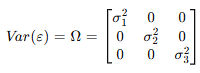

GLS assumption (Errors may be heteroskedastic and Errors may be correlated)

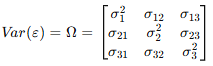

---

## **5. Robust Standard Errors**

* If changing the model is difficult, use **HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors**.
* Example: Newey-West standard errors in time series regressions.
* Coefficients remain the same, but inference (t-tests, confidence intervals) is valid despite autocorrelation.

---

## **6. Remove Outliers or Structural Breaks**

* Sudden jumps or outliers in data can induce autocorrelation.
* Options:

  * Remove or Winsorize outliers
  * Include dummy variables for structural breaks

---

### **Key Notes**

* Simply ignoring autocorrelation may not bias coefficients but will **invalidate hypothesis tests and prediction intervals**.
* In practice, a combination works best: e.g., **difference the series + use GLS or robust standard errors**.


